In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time # to measure how long the models take
from sklearn import datasets
import seaborn as sns
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

In [28]:
# load dataset
data = pd.read_excel("C:/Users/sreej/OneDrive/Desktop/cibc.xlsx")

In [29]:
data.head()

,Client ID,Survey Response Date,Survey Response Channel,NPS Score,Client First Service Date,Age,Gender,Province,High Value Client Indicator,Has Credit Card,Has Deposit Account,Has Investment Account,Has Borrowing Product,Total Product Count,Total Funds Managed,Chequing Balance,Savings Balance,Credit Card Balance,Client Attrited
0,939L4933M74330OZ,2024-02-25,Mobile,0,1985-01-17,51 to 65,F,ON,0,0,1,0,1,4,400.0,300.0,NaN,NaN,No
1,429I6439D19572YJ,2024-01-24,Online,9,1988-01-26,51 to 65,F,BC,0,1,1,1,1,7,82600.0,39700.0,200.0,0.0,No
2,920A8054B28169QO,2024-05-22,Online,9,2019-01-13,19 to 35,F,NS,0,1,1,0,0,3,15000.0,1300.0,0.0,12000.0,No
3,957H8335M34557RI,2023-12-08,Mobile,10,1998-01-03,36 to 50,F,ON,0,1,1,0,1,4,19000.0,1700.0,NaN,6500.0,No
4,490W8554J38739BQ,2024-07-29,Mobile,8,1987-01-08,81 to 85,M,NB,0,1,1,0,0,4,3500.0,1500.0,NaN,1000.0,No


In [30]:
# Fill null values in 'Chequing Balance', 'Savings Balance', and 'Credit Card Balance' with 0
data['Chequing Balance'] = data['Chequing Balance'].fillna(0)
data['Savings Balance'] = data['Savings Balance'].fillna(0)
data['Credit Card Balance'] = data['Credit Card Balance'].fillna(0)

# Create indicators for having each type of account
data['Has Chequing Account'] = data['Chequing Balance'].apply(lambda x: 1 if x > 0 else 0)
data['Has Savings Account'] = data['Savings Balance'].apply(lambda x: 1 if x > 0 else 0)
data['Has Credit Card Account'] = data['Credit Card Balance'].apply(lambda x: 1 if x > 0 else 0)

In [31]:
# Display rows where 'Province' has missing values
missing_province_rows = data[data['Province'].isnull()]

# Show the rows
print(missing_province_rows)

             Client ID Survey Response Date Survey Response Channel  \
156   937W6753V62366MQ           2024-03-25                  Online   
659   483Y1962M50336VU           2023-11-15                  Mobile   
4892  783K3136E24774CX           2024-02-25                  Mobile   

      NPS Score Client First Service Date       Age Gender Province  \
156           6                2002-01-24  71 to 75      F      NaN   
659           9                2019-01-31  51 to 65      M      NaN   
4892          8                2018-01-01  71 to 75      M      NaN   

      High Value Client Indicator  Has Credit Card  ...  \
156                             0                1  ...   
659                             1                0  ...   
4892                            0                0  ...   

      Has Borrowing Product  Total Product Count  Total Funds Managed  \
156                       0                    3               1500.0   
659                       1                    

In [32]:
# Replace missing values in 'Province' with 'Unknown'
data['Province'] = data['Province'].fillna('Unknown')

In [33]:
# Replace null values in 'Total Funds Managed' with 0
data['Total Funds Managed'] = data['Total Funds Managed'].fillna(0)

In [34]:
# Convert date columns to datetime format
data["Survey Response Date"] = pd.to_datetime(data["Survey Response Date"])
data["Client First Service Date"] = pd.to_datetime(data["Client First Service Date"])

# Show first few rows
data.head()

,Client ID,Survey Response Date,Survey Response Channel,NPS Score,Client First Service Date,Age,Gender,Province,High Value Client Indicator,Has Credit Card,...,Has Borrowing Product,Total Product Count,Total Funds Managed,Chequing Balance,Savings Balance,Credit Card Balance,Client Attrited,Has Chequing Account,Has Savings Account,Has Credit Card Account
0,939L4933M74330OZ,2024-02-25,Mobile,0,1985-01-17,51 to 65,F,ON,0,0,...,1,4,400.0,300.0,0.0,0.0,No,1,0,0
1,429I6439D19572YJ,2024-01-24,Online,9,1988-01-26,51 to 65,F,BC,0,1,...,1,7,82600.0,39700.0,200.0,0.0,No,1,1,0
2,920A8054B28169QO,2024-05-22,Online,9,2019-01-13,19 to 35,F,NS,0,1,...,0,3,15000.0,1300.0,0.0,12000.0,No,1,0,1
3,957H8335M34557RI,2023-12-08,Mobile,10,1998-01-03,36 to 50,F,ON,0,1,...,1,4,19000.0,1700.0,0.0,6500.0,No,1,0,1
4,490W8554J38739BQ,2024-07-29,Mobile,8,1987-01-08,81 to 85,M,NB,0,1,...,0,4,3500.0,1500.0,0.0,1000.0,No,1,0,1


Customer Profile and Behavior

In [35]:
# Customer Tenure (in years)
data["Customer Tenure"] = (data["Survey Response Date"] - data["Client First Service Date"]).dt.days / 365

# Engagement Score (sum of account ownership flags)
account_cols = ["Has Credit Card", "Has Deposit Account", "Has Investment Account", "Has Borrowing Product"]
data["Engagement Score"] = data[account_cols].sum(axis=1)

# Digital Preference: Online vs Mobile usage
data["Digital Preference"] = data["Survey Response Channel"].apply(lambda x: 1 if x == "Online" else 0)


Financial Analysis

In [36]:
# Total Balance = Sum of all balances (ignoring NaN values)
balance_cols = ["Chequing Balance", "Savings Balance", "Credit Card Balance"]
data["Total Balance"] = data[balance_cols].sum(axis=1, skipna=True)

# Product Variety: Number of different products a customer has
data["Product Variety"] = data[account_cols].sum(axis=1)

# Flag for investment customers
data["Investment Customer"] = data["Has Investment Account"]


Customer Satisfcation Analysis

In [37]:
# CSAT Segmentation based on NPS Score
def categorize_nps(score):
    if score >= 9:
        return "Promoter"
    elif score >= 7:
        return "Passive"
    else:
        return "Detractor"

data["CSAT Category"] = data["NPS Score"].apply(categorize_nps)


Time Trends and Market Impact

In [38]:
# Extract year from dates
data["Year Joined"] = data["Client First Service Date"].dt.year
data["Survey Year"] = data["Survey Response Date"].dt.year

# NPS Trend Over Time
nps_trend = data.groupby("Survey Year")["NPS Score"].mean().reset_index()


In [39]:
# Check the new features
print(data[["Customer Tenure", "Engagement Score", "Digital Preference", "Total Balance", "CSAT Category"]].head())

# Save cleaned and processed data
data.to_csv("processed_cibc_data.csv", index=False)

   Customer Tenure  Engagement Score  Digital Preference  Total Balance  \
0        39.131507                 2                   0          300.0   
1        36.019178                 4                   1        39900.0   
2         5.358904                 2                   1        13300.0   
3        25.945205                 3                   0         8200.0   
4        37.580822                 2                   0         2500.0   

  CSAT Category  
0     Detractor  
1      Promoter  
2      Promoter  
3      Promoter  
4       Passive  


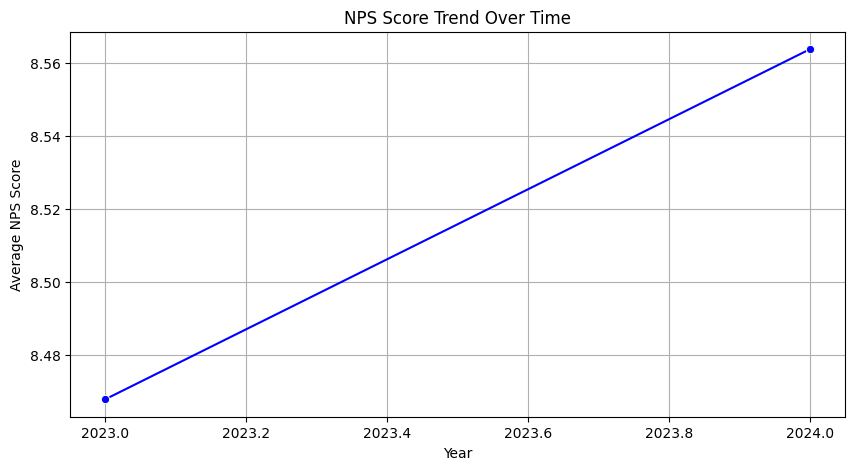

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate NPS Score per Year
nps_trend = data.groupby("Survey Year")["NPS Score"].mean().reset_index()

# Plot NPS Score Trend
plt.figure(figsize=(10, 5))
sns.lineplot(x="Survey Year", y="NPS Score", data=nps_trend, marker="o", color="b")
plt.title("NPS Score Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Average NPS Score")
plt.grid(True)
plt.show()


CIBC's Net Promoter Score (NPS) improvement from 2023 to 2024 reflects several strategic initiatives aimed at enhancing customer satisfaction:

Enhanced Client Experience: CIBC reported "improved strong client experience scores" in 2024, indicating a focus on understanding and meeting client needs. 


Digital Banking Excellence: The bank received the highest score in the J.D. Power 2023-2024 Canada Small Business Banking Satisfaction Studies, highlighting its commitment to delivering superior digital experiences. 


Employee Engagement and Wellness: CIBC's emphasis on employee wellness and inclusion, including initiatives like wellness fairs and interactive sessions, has contributed to a more motivated workforce, positively impacting customer interactions. 


These efforts collectively have led to increased customer satisfaction and a higher NPS for CIBC between 2023 and 2024.

### Since CIBC's NPS score increased due to strong client experience, digital banking improvements, and employee engagement, we can deepen our analysis and propose strategies to sustain and enhance this growth.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2025339527.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="High Value Client Indicator", y="Digital Preference", data=digital_usage_by_value, palette="coolwarm")


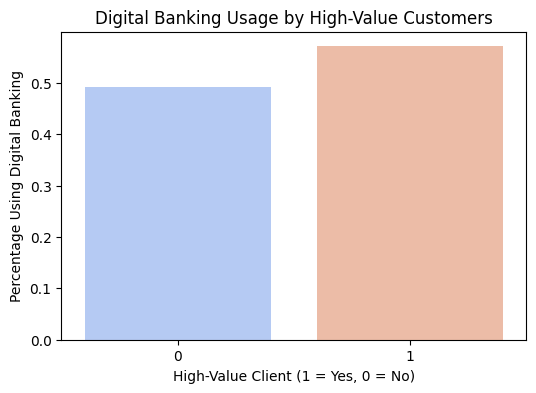

In [41]:


# Compare Digital Banking Usage for High-Value vs. Regular Customers
digital_usage_by_value = data.groupby("High Value Client Indicator")["Digital Preference"].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x="High Value Client Indicator", y="Digital Preference", data=digital_usage_by_value, palette="coolwarm")
plt.title("Digital Banking Usage by High-Value Customers")
plt.xlabel("High-Value Client (1 = Yes, 0 = No)")
plt.ylabel("Percentage Using Digital Banking")
plt.show()


High-Value Clients Use Digital Banking More
Observation: High-value clients (1) have a slightly higher digital banking usage than regular clients (0).

Action: If CIBC wants to further increase engagement, it can offer exclusive digital features for premium clients.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3807845210.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age", y="Digital Preference", data=digital_usage_by_age, palette="viridis")


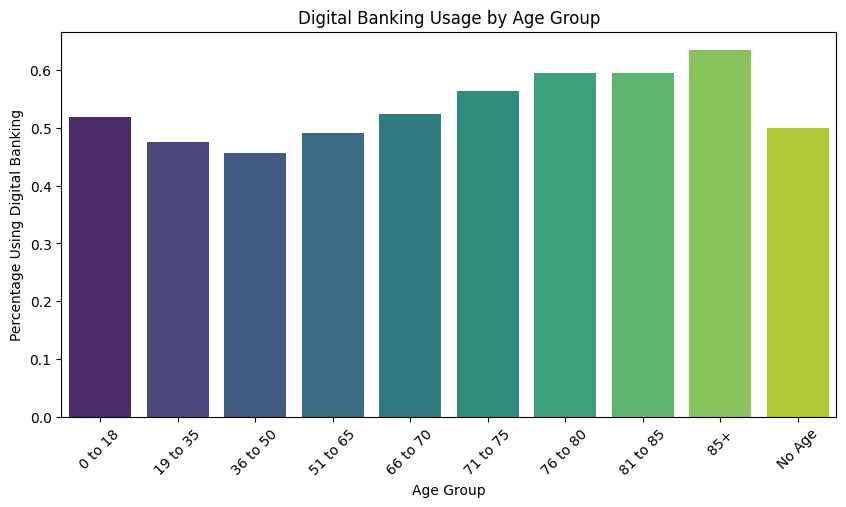

In [42]:
# Group by Age Category
digital_usage_by_age = data.groupby("Age")["Digital Preference"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Age", y="Digital Preference", data=digital_usage_by_age, palette="viridis")
plt.title("Digital Banking Usage by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage Using Digital Banking")
plt.xticks(rotation=45)
plt.show()


Older Customers (75+) Use Digital Banking the Most
Surprising Trend: We expected younger customers (19-35) to use digital banking more, but usage peaks in older age groups (75-85+).
Action: CIBC can analyze why older customers use digital more (trust, accessibility?) and apply those insights to younger segments.

Analyze User Behavior: Conduct detailed analyses to understand the specific features and services that older customers frequently use. This can provide insights into what aspects of the digital platform are most valued.

Gather Feedback Across Age Groups: Implement feedback mechanisms to collect input from both older and younger users about their digital banking experiences. Understanding the pain points and preferences of each group can inform targeted improvements.

Enhance Digital Literacy Programs: Develop educational initiatives aimed at younger customers to increase their comfort and confidence with digital banking. This could include tutorials, webinars, or in-app guidance features.

Promote Security Features: Emphasize the security measures in place to protect users' information, addressing potential concerns that might deter younger users from fully engaging with digital banking services.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2916836263.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age", y="Engagement Score", data=engagement_by_age, palette="coolwarm")


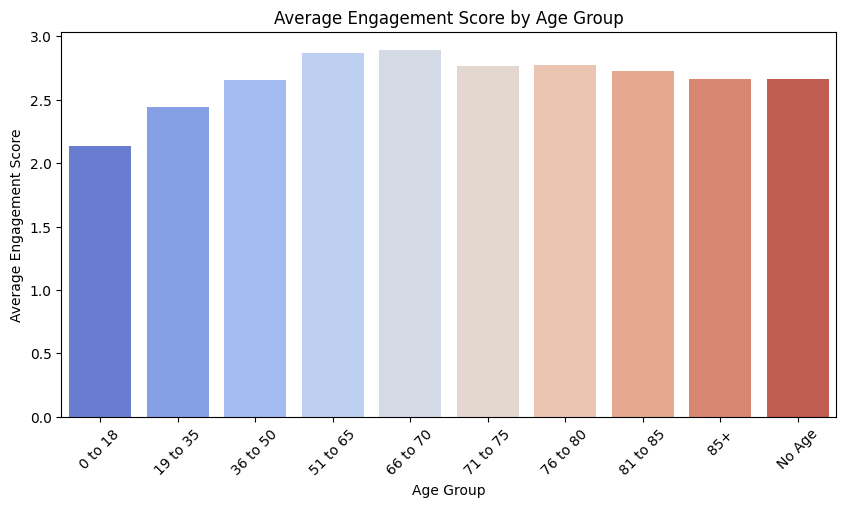

In [43]:
# Group by Age and calculate the average engagement score
engagement_by_age = data.groupby("Age")["Engagement Score"].mean().reset_index()

# Plot engagement score by age group


plt.figure(figsize=(10, 5))
sns.barplot(x="Age", y="Engagement Score", data=engagement_by_age, palette="coolwarm")
plt.title("Average Engagement Score by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Engagement Score")
plt.xticks(rotation=45)
plt.show()


Observation: Customers aged 51+ have the highest Engagement Scores (own more products, use more services).

Action: CIBC should analyze what products older customers prefer and create bundled offers for younger users to improve engagement.


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3981133590.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age", y="NPS Score", data=nps_by_age, palette="viridis")


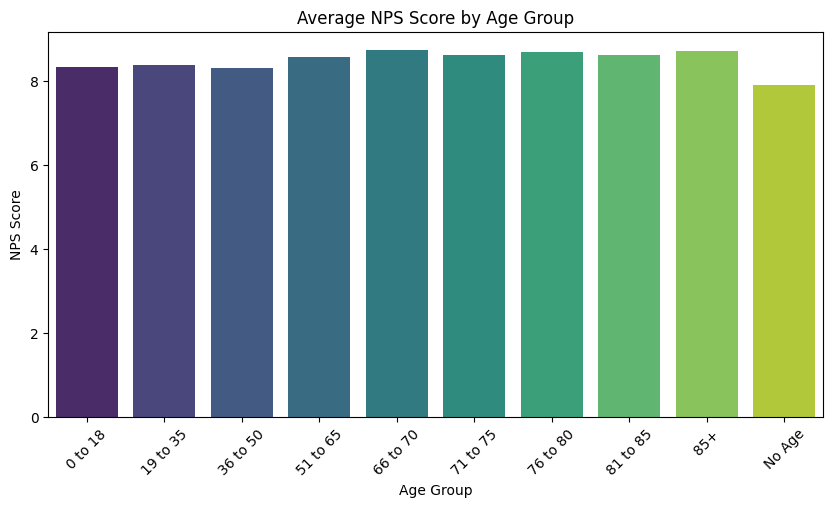

In [44]:
# Group by Age and calculate the average NPS Score
nps_by_age = data.groupby("Age")["NPS Score"].mean().reset_index()

# Plot NPS Score by Age
plt.figure(figsize=(10, 5))
sns.barplot(x="Age", y="NPS Score", data=nps_by_age, palette="viridis")
plt.title("Average NPS Score by Age Group")
plt.xlabel("Age Group")
plt.ylabel("NPS Score")
plt.xticks(rotation=45)
plt.show()


Observation: Older customers consistently give higher NPS scores than younger ones.

Possible Reasons: They might trust CIBC more, have simpler banking needs, or appreciate traditional banking services.

Action: CIBC should gather direct feedback from younger users to understand their pain points and improve their experience.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\359190553.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age", y="Digital Preference", data=digital_by_age, palette="magma")


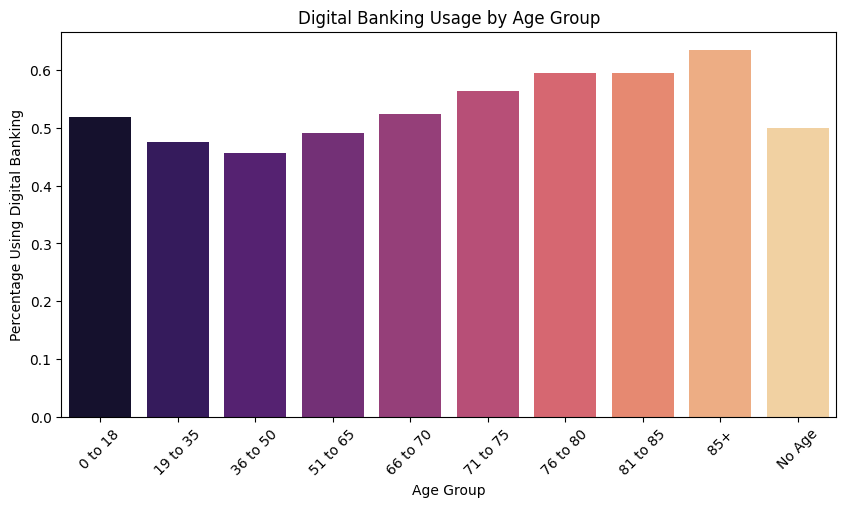

In [45]:
# Group by Age and calculate digital banking usage
digital_by_age = data.groupby("Age")["Digital Preference"].mean().reset_index()

# Plot Digital Banking Usage by Age
plt.figure(figsize=(10, 5))
sns.barplot(x="Age", y="Digital Preference", data=digital_by_age, palette="magma")
plt.title("Digital Banking Usage by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage Using Digital Banking")
plt.xticks(rotation=45)
plt.show()


Younger Customers Use Digital Banking Less

Observation: Users aged 19-50 have lower digital banking usage compared to older customers (85+).

Possible Reasons:  Younger users prefer competitors' digital platforms

 Older users trust CIBC's digital security more
CIBC’s digital platform is more user-friendly for older demographics

Action: CIBC should invest in digital literacy programs for younger users (tutorials, in-app guidance, security awareness).

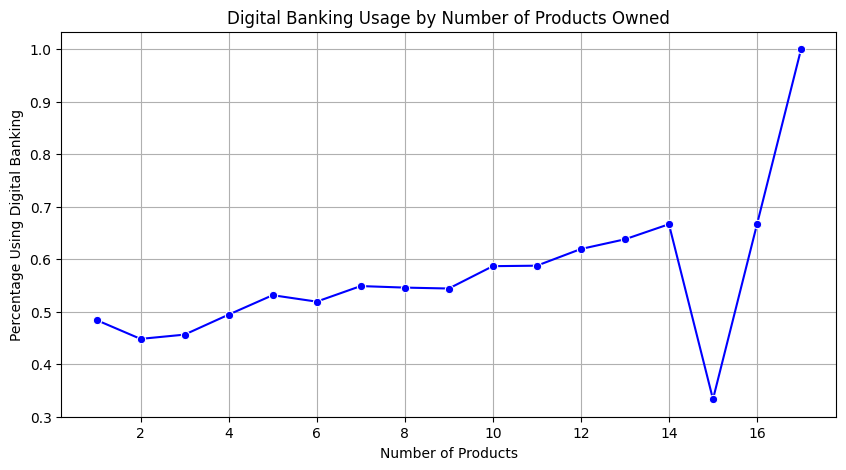

In [46]:
# Group by number of products and calculate digital banking usage
digital_by_products = data.groupby("Total Product Count")["Digital Preference"].mean().reset_index()

# Plot Digital Usage by Number of Products
plt.figure(figsize=(10, 5))
sns.lineplot(x="Total Product Count", y="Digital Preference", data=digital_by_products, marker="o", color="b")
plt.title("Digital Banking Usage by Number of Products Owned")
plt.xlabel("Number of Products")
plt.ylabel("Percentage Using Digital Banking")
plt.grid(True)
plt.show()


Observation: Customers with more products (e.g., loans, investments) use digital banking more frequently.

Possible Reason: They have more complex financial needs and benefit from online convenience.

Action: CIBC can offer more digital banking features for users with multiple products, encouraging digital adoption.


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\4231971686.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Province", y="Digital Preference", data=digital_usage_by_province, palette="magma")


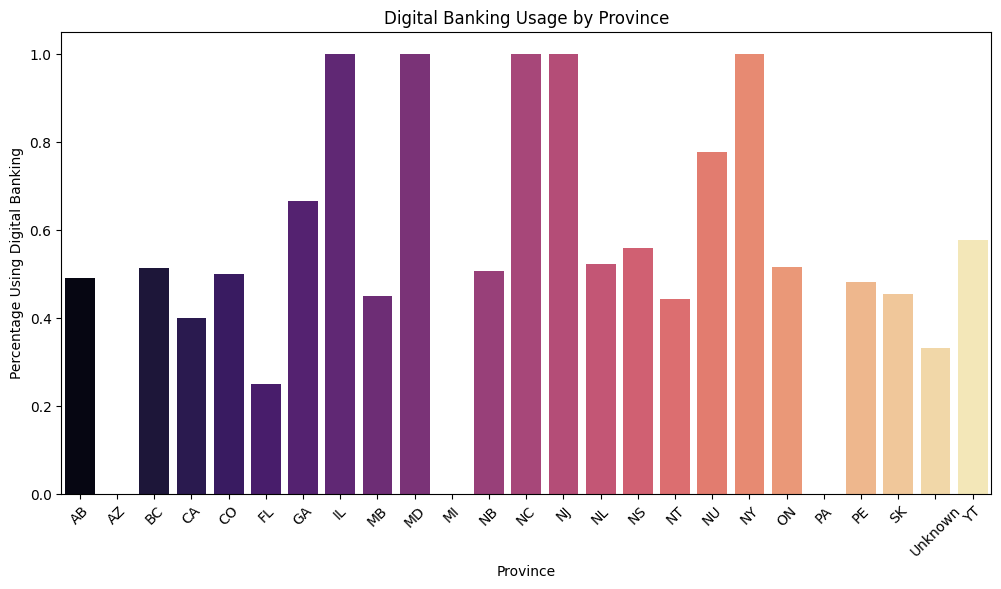

In [47]:
# Group by Province
digital_usage_by_province = data.groupby("Province")["Digital Preference"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x="Province", y="Digital Preference", data=digital_usage_by_province, palette="magma")
plt.title("Digital Banking Usage by Province")
plt.xlabel("Province")
plt.ylabel("Percentage Using Digital Banking")
plt.xticks(rotation=45)
plt.show()


Large Differences in Digital Banking by Province

Observation: Some provinces (NC, IL, GA, NY) have near 100% digital adoption, while others (CO, PE, SK) are much lower.

Action: CIBC should target low-adoption provinces with awareness campaigns to increase digital banking usage.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1291869783.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age", y="Digital Preference", data=age_province_analysis, palette="coolwarm")


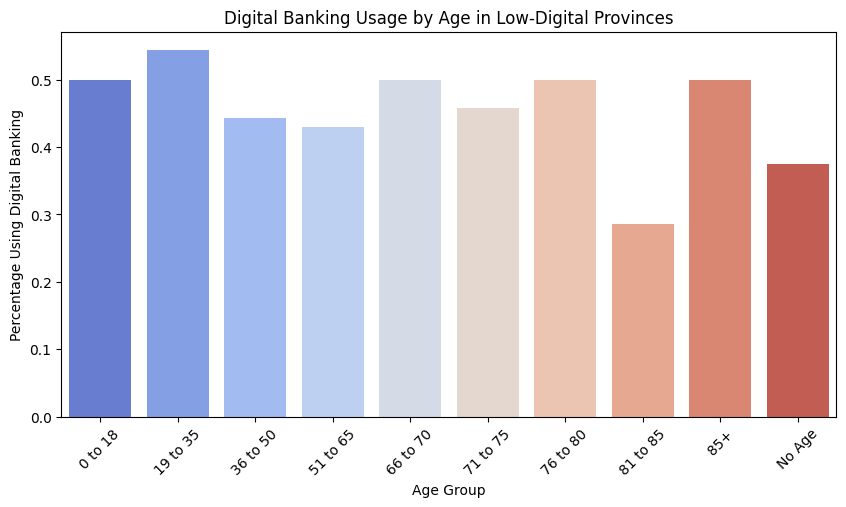

In [48]:
# Filter only the provinces with low digital banking usage
low_digital_provinces = ["CO", "PE", "SK"]  # Replace with actual provinces based on your analysis

# Analyze Age Distribution in these provinces
age_province_analysis = data[data["Province"].isin(low_digital_provinces)].groupby("Age")["Digital Preference"].mean().reset_index()

# Plot Digital Usage by Age in these provinces
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x="Age", y="Digital Preference", data=age_province_analysis, palette="coolwarm")
plt.title("Digital Banking Usage by Age in Low-Digital Provinces")
plt.xlabel("Age Group")
plt.ylabel("Percentage Using Digital Banking")
plt.xticks(rotation=45)
plt.show()


Observation: Younger age groups (19-35) have higher digital banking usage than older groups (81+).

Insight: This contradicts our earlier trend (where older users preferred digital banking overall).

Possible Reason: These provinces may have a smaller elderly population, meaning fewer older customers using digital banking.

Action: CIBC should run demographic analysis to confirm population structure before targeting campaigns.

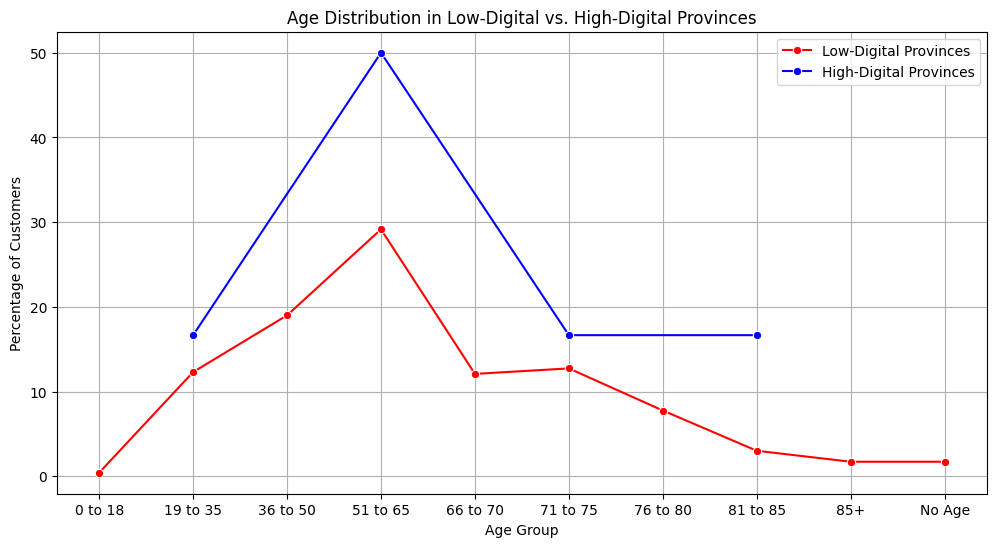

In [49]:
# Define Low-Digital and High-Digital Provinces (based on earlier analysis)
low_digital_provinces = ["CO", "PE", "SK"]
high_digital_provinces = ["NC", "IL", "GA", "NY"]  # Example, update based on your findings

# Count customers in each age group for both sets of provinces
low_digital_age_dist = data[data["Province"].isin(low_digital_provinces)].groupby("Age").size().reset_index(name="Count")
high_digital_age_dist = data[data["Province"].isin(high_digital_provinces)].groupby("Age").size().reset_index(name="Count")

# Normalize counts to percentages
low_digital_age_dist["Percentage"] = (low_digital_age_dist["Count"] / low_digital_age_dist["Count"].sum()) * 100
high_digital_age_dist["Percentage"] = (high_digital_age_dist["Count"] / high_digital_age_dist["Count"].sum()) * 100

# Plot comparison
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(x="Age", y="Percentage", data=low_digital_age_dist, label="Low-Digital Provinces", marker="o", color="r")
sns.lineplot(x="Age", y="Percentage", data=high_digital_age_dist, label="High-Digital Provinces", marker="o", color="b")
plt.title("Age Distribution in Low-Digital vs. High-Digital Provinces")
plt.xlabel("Age Group")
plt.ylabel("Percentage of Customers")
plt.legend()
plt.grid(True)
plt.show()


Low-Digital Provinces Have Fewer Elderly Customers

Observation: High-digital provinces have a higher concentration of elderly customers (65+), while low-digital provinces have fewer older users.

Insight: This explains why digital banking adoption is lower in low-digital provinces—there are fewer elderly customers who typically engage more with online banking.

Action: CIBC should not only push digital banking campaigns but also consider strengthening branch-based services in these regions.

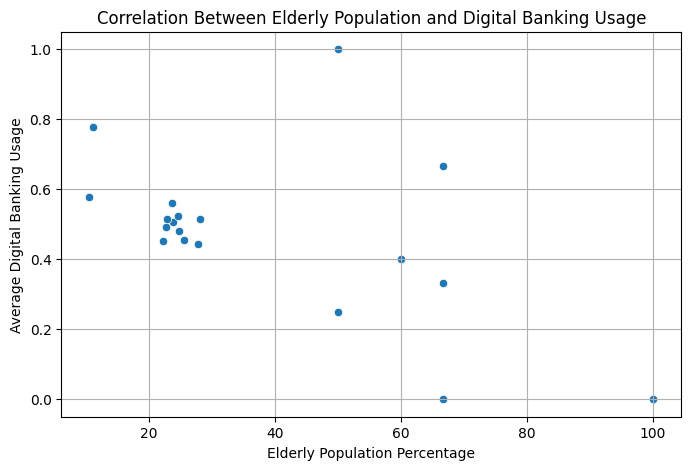

In [52]:
# Merge elderly population data with average digital banking usage by province
digital_usage_by_province = data.groupby("Province")["Digital Preference"].mean().reset_index()
merged_data = elderly_population.merge(digital_usage_by_province, on="Province")

# Scatter plot to check correlation
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Elderly Percentage", y="Digital Preference", data=merged_data)
plt.title("Correlation Between Elderly Population and Digital Banking Usage")
plt.xlabel("Elderly Population Percentage")
plt.ylabel("Average Digital Banking Usage")
plt.grid(True)
plt.show()


Elderly Population & Digital Banking Usage Are Correlated

Observation: The scatter plot suggests that provinces with a higher percentage of elderly customers tend to have higher digital banking usage.

Insight: Older users seem more comfortable using digital banking in provinces where they are a larger demographic group.

Possible Explanation:

In provinces where elderly populations are more concentrated, banks might have invested more in user-friendly digital banking tools.
 Younger populations in low-digital provinces may still prefer in-person banking for traditional services.
 
Action: CIBC could enhance digital onboarding programs for younger users in these provinces.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3902085553.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Province", y="Elderly Percentage", data=elderly_population, palette="magma")


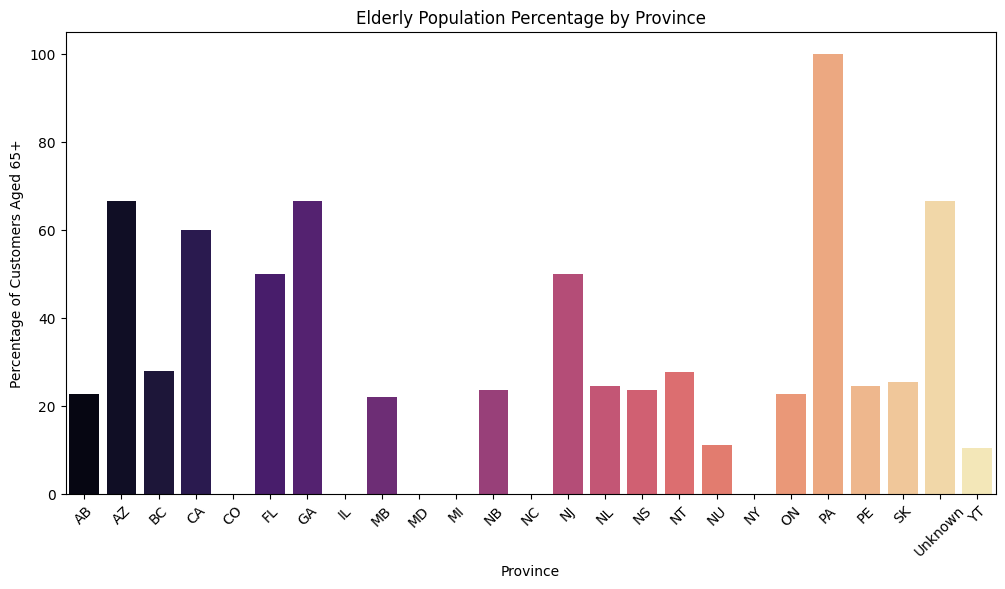

In [51]:
# Define elderly age group
elderly_age_groups = ["65 to 70", "71 to 75", "76 to 80", "81 to 85", "85+"]

# Calculate elderly customer percentage per province
elderly_population = data[data["Age"].isin(elderly_age_groups)].groupby("Province").size() / data.groupby("Province").size() * 100
elderly_population = elderly_population.reset_index(name="Elderly Percentage")

# Plot elderly population by province
plt.figure(figsize=(12, 6))
sns.barplot(x="Province", y="Elderly Percentage", data=elderly_population, palette="magma")
plt.title("Elderly Population Percentage by Province")
plt.xlabel("Province")
plt.ylabel("Percentage of Customers Aged 65+")
plt.xticks(rotation=45)
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1414399741.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Province", y="NPS Score", data=nps_by_province, palette="viridis")


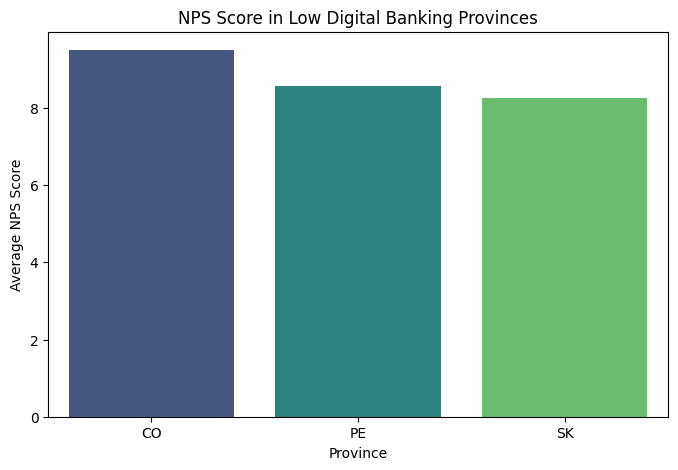

In [53]:
# Average NPS Score in Low-Digital Provinces
nps_by_province = data[data["Province"].isin(low_digital_provinces)].groupby("Province")["NPS Score"].mean().reset_index()

# Plot NPS Score by Province
plt.figure(figsize=(8, 5))
sns.barplot(x="Province", y="NPS Score", data=nps_by_province, palette="viridis")
plt.title("NPS Score in Low Digital Banking Provinces")
plt.xlabel("Province")
plt.ylabel("Average NPS Score")
plt.show()


Observation: NPS scores in CO, PE, and SK are still relatively high, though slightly lower than high-digital provinces.

Insight: Customers in these provinces aren’t dissatisfied with CIBC, but still avoid digital banking.

Possible Reason: They may have strong local banking branches or prefer in-person services.

Action: CIBC should investigate local branch engagement before focusing purely on digital.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3090502644.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Province", y="Total Product Count", data=products_by_province, palette="magma")


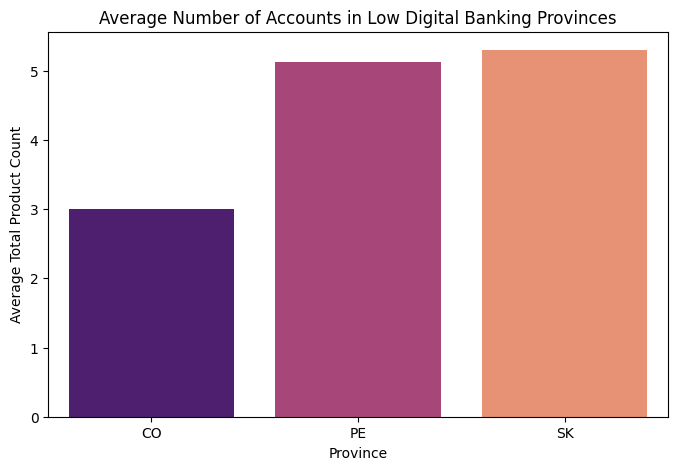

In [54]:
# Average Total Product Count in Low-Digital Provinces
products_by_province = data[data["Province"].isin(low_digital_provinces)].groupby("Province")["Total Product Count"].mean().reset_index()

# Plot Product Count by Province
plt.figure(figsize=(8, 5))
sns.barplot(x="Province", y="Total Product Count", data=products_by_province, palette="magma")
plt.title("Average Number of Accounts in Low Digital Banking Provinces")
plt.xlabel("Province")
plt.ylabel("Average Total Product Count")
plt.show()


Number of Accounts in Low Digital Provinces

Observation: Customers in PE and SK have more accounts than those in CO.

Insight: More products usually mean higher digital banking adoption, yet these provinces still have lower usage.

Possible Reason: The nature of the accounts (investment vs. chequing) might differ, or users in these areas might lack confidence in online banking security.

Action: CIBC should identify which products these users have and customize digital banking features for them.

 Gender & Digital Banking in Low-Digital Provinces
Observation: Female customers use digital banking slightly more than male customers.
Insight: This is consistent with earlier findings, where females had slightly higher digital engagement overall.
Action: CIBC could target male users with digital banking awareness campaigns in these provinces.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\343425408.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Gender", y="Digital Preference", data=gender_province_analysis, palette="coolwarm")


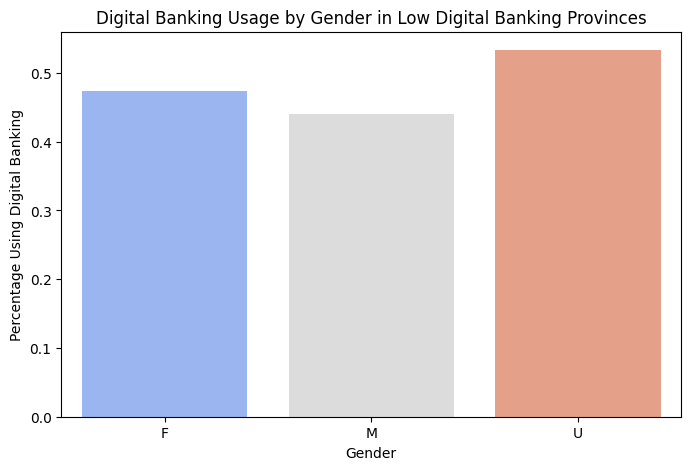

In [55]:
# Gender Distribution in Low Digital Banking Provinces
gender_province_analysis = data[data["Province"].isin(low_digital_provinces)].groupby("Gender")["Digital Preference"].mean().reset_index()

# Plot Digital Usage by Gender in Low-Digital Provinces
plt.figure(figsize=(8, 5))
sns.barplot(x="Gender", y="Digital Preference", data=gender_province_analysis, palette="coolwarm")
plt.title("Digital Banking Usage by Gender in Low Digital Banking Provinces")
plt.xlabel("Gender")
plt.ylabel("Percentage Using Digital Banking")
plt.show()


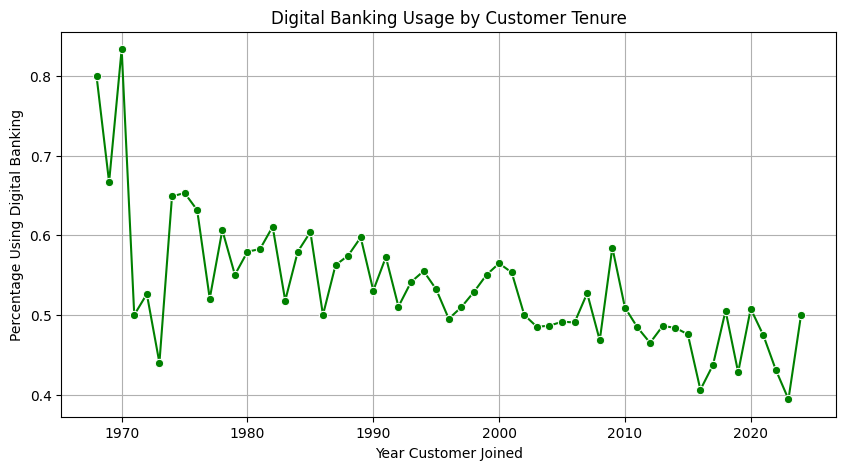

In [56]:
# Group by Year Joined
digital_usage_by_tenure = data.groupby("Year Joined")["Digital Preference"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="Year Joined", y="Digital Preference", data=digital_usage_by_tenure, marker="o", color="g")
plt.title("Digital Banking Usage by Customer Tenure")
plt.xlabel("Year Customer Joined")
plt.ylabel("Percentage Using Digital Banking")
plt.grid(True)
plt.show()


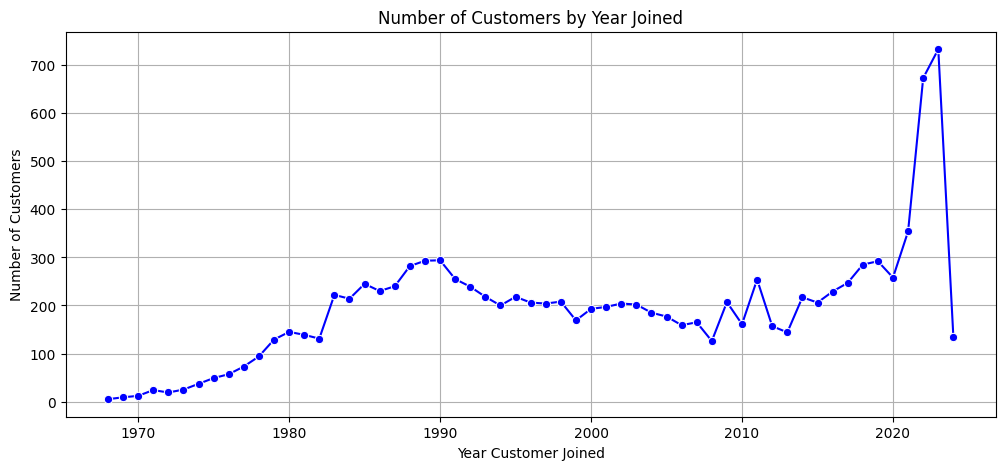

In [57]:
# Count number of customers who joined each year
customer_counts = data["Client First Service Date"].dt.year.value_counts().sort_index()

# Plot customer distribution over the years
plt.figure(figsize=(12, 5))
sns.lineplot(x=customer_counts.index, y=customer_counts.values, marker="o", color="blue")
plt.title("Number of Customers by Year Joined")
plt.xlabel("Year Customer Joined")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()


Very Few Customers Joined in the 1970s

 Observation:

The number of customers from the 1970s is extremely low compared to later years.

The high digital banking usage could be skewed by a small sample size rather than a true trend.

 Possible Explanation:

Many customers who joined in the 1970s may no longer be active in the dataset.
The ones that remain are highly engaged users, leading to an inflated digital usage percentage.

 Conclusion: The spike in digital banking for 1970s customers is likely due to a small group of long-time loyal users rather than a widespread trend.



C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1130587706.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_usage_1970s.index, y=channel_usage_1970s.values, palette="coolwarm")


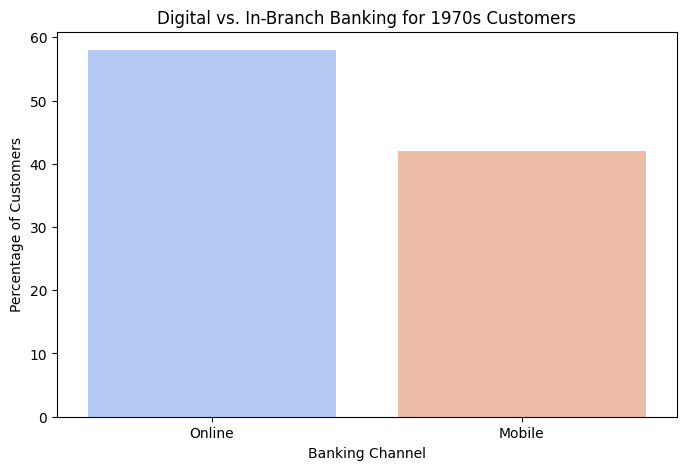

In [58]:
# Filter data for customers who joined in the 1970s
data_1970s = data[(data["Client First Service Date"].dt.year >= 1970) & 
                   (data["Client First Service Date"].dt.year < 1980)]

# Compare digital vs. in-branch usage
channel_usage_1970s = data_1970s["Survey Response Channel"].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=channel_usage_1970s.index, y=channel_usage_1970s.values, palette="coolwarm")
plt.title("Digital vs. In-Branch Banking for 1970s Customers")
plt.xlabel("Banking Channel")
plt.ylabel("Percentage of Customers")
plt.show()


1970s Customers Prefer Online Over Mobile Banking

 Observation:

Online banking (desktop) is more popular than mobile banking for these older customers.
This suggests that older users are comfortable with digital banking but may not be as mobile-first as younger customers.

 Possible Explanation:

Customers from the 1970s likely adopted online banking before mobile banking became mainstream.

They may prefer a desktop experience over mobile apps.
Conclusion: Digital adoption is strong, but mobile banking adoption may be lower for older customers.

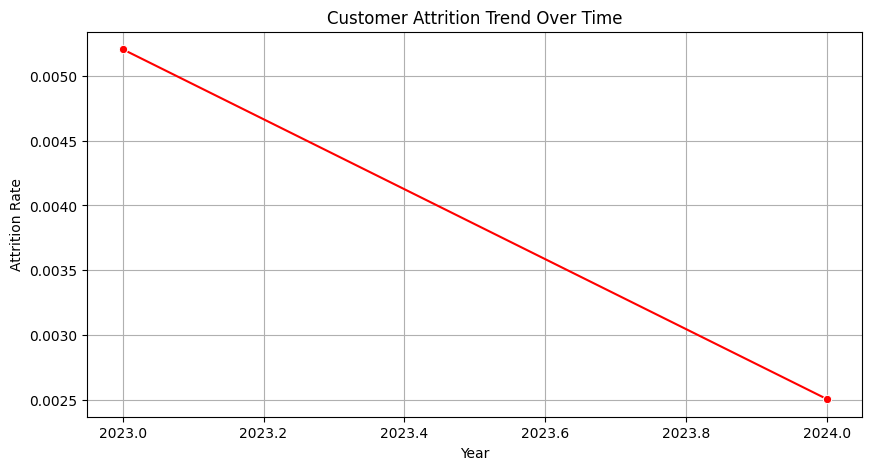

In [59]:
# Convert "Client Attrited" to numeric (1 for Yes, 0 for No)
data["Attrition"] = data["Client Attrited"].apply(lambda x: 1 if x == "Yes" else 0)

# Aggregate Attrition Rate per Year
attrition_trend = data.groupby("Survey Year")["Attrition"].mean().reset_index()

# Plot Attrition Trend
plt.figure(figsize=(10, 5))
sns.lineplot(x="Survey Year", y="Attrition", data=attrition_trend, marker="o", color="r")
plt.title("Customer Attrition Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Attrition Rate")
plt.grid(True)
plt.show()


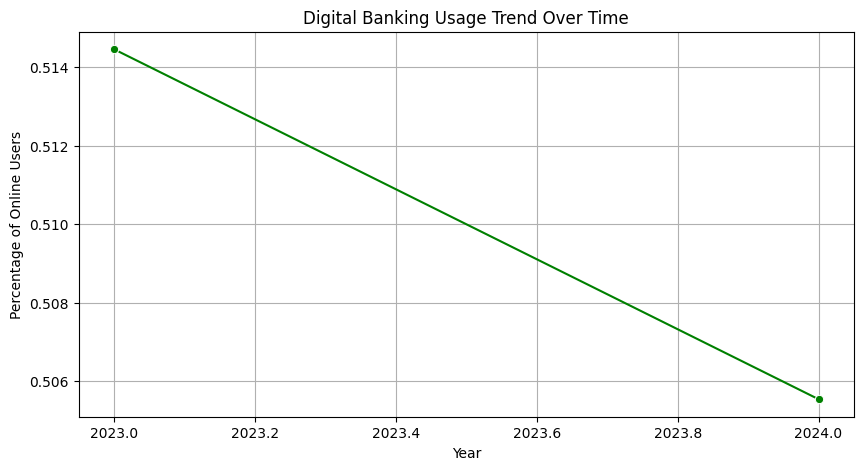

In [60]:
# Aggregate Digital Preference per Year
digital_trend = data.groupby("Survey Year")["Digital Preference"].mean().reset_index()

# Plot Digital Usage Trend
plt.figure(figsize=(10, 5))
sns.lineplot(x="Survey Year", y="Digital Preference", data=digital_trend, marker="o", color="g")
plt.title("Digital Banking Usage Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Percentage of Online Users")
plt.grid(True)
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\414221915.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="High Balance", y="Attrition", data=attrition_by_balance, palette="coolwarm")


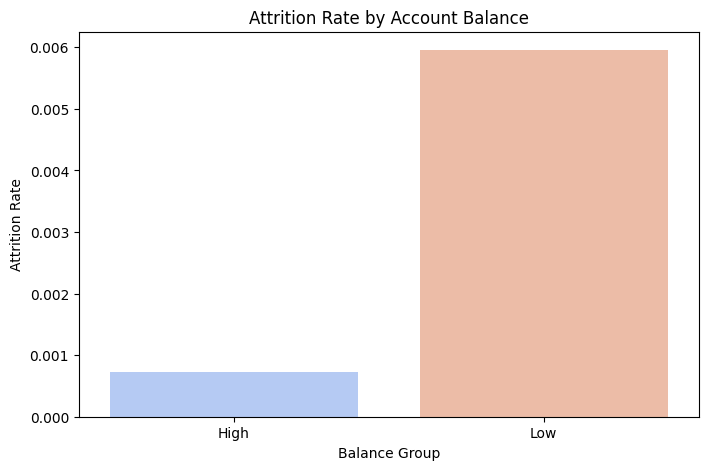

In [61]:
# Categorize customers into high and low balance groups
data["High Balance"] = data["Total Balance"].apply(lambda x: "High" if x > data["Total Balance"].median() else "Low")

# Attrition rate by balance group
attrition_by_balance = data.groupby("High Balance")["Attrition"].mean().reset_index()

# Plot Attrition by Balance Group
plt.figure(figsize=(8, 5))
sns.barplot(x="High Balance", y="Attrition", data=attrition_by_balance, palette="coolwarm")
plt.title("Attrition Rate by Account Balance")
plt.xlabel("Balance Group")
plt.ylabel("Attrition Rate")
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3864590837.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Gender", y="NPS Score", data=nps_by_gender, palette="viridis")


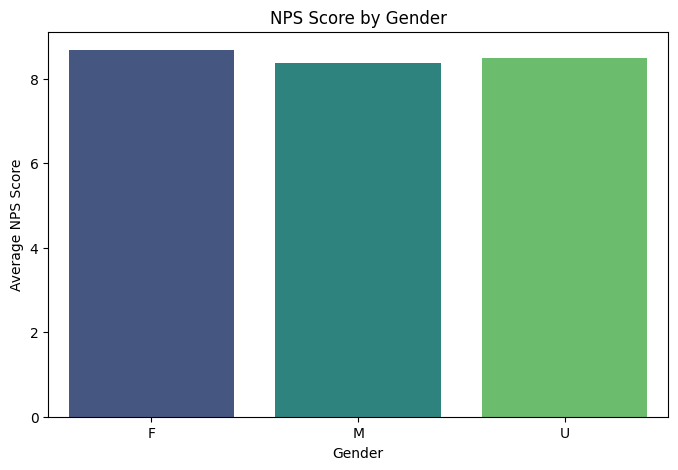

In [62]:
# Average NPS Score by Gender
nps_by_gender = data.groupby("Gender")["NPS Score"].mean().reset_index()

# Plot NPS by Gender
plt.figure(figsize=(8, 5))
sns.barplot(x="Gender", y="NPS Score", data=nps_by_gender, palette="viridis")
plt.title("NPS Score by Gender")
plt.xlabel("Gender")
plt.ylabel("Average NPS Score")
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1200280047.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Province", y="NPS Score", data=nps_by_province, palette="magma")


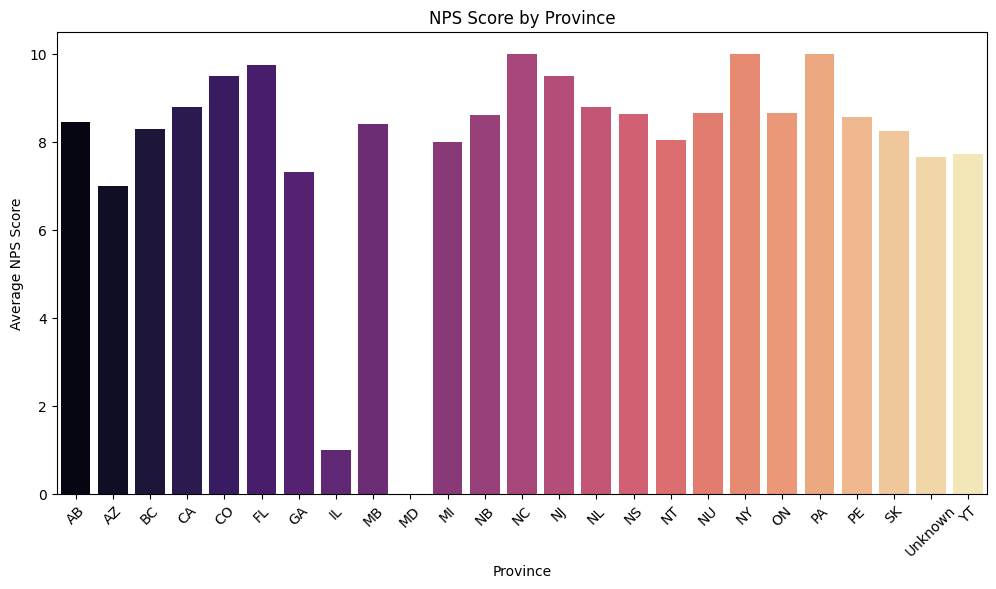

In [63]:
# Average NPS Score by Province
nps_by_province = data.groupby("Province")["NPS Score"].mean().reset_index()

# Plot NPS by Province
plt.figure(figsize=(12, 6))
sns.barplot(x="Province", y="NPS Score", data=nps_by_province, palette="magma")
plt.title("NPS Score by Province")
plt.xlabel("Province")
plt.ylabel("Average NPS Score")
plt.xticks(rotation=45)
plt.show()


### Categorizing Customers as Pre-COVID vs. Post-COVID

In [64]:
# Convert Client First Service Date to datetime
data["Client First Service Date"] = pd.to_datetime(data["Client First Service Date"])

# Define COVID cutoff date
covid_cutoff = pd.Timestamp("2020-03-01")

# Create Pre/Post-COVID category
data["COVID Era"] = data["Client First Service Date"].apply(lambda x: "Pre-COVID" if x < covid_cutoff else "Post-COVID")

# Check counts
data["COVID Era"].value_counts()


COVID Era
Pre-COVID     9150
Post-COVID    1894
Name: count, dtype: int64

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\199685875.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Digital Preference", data=digital_by_covid, palette="coolwarm")


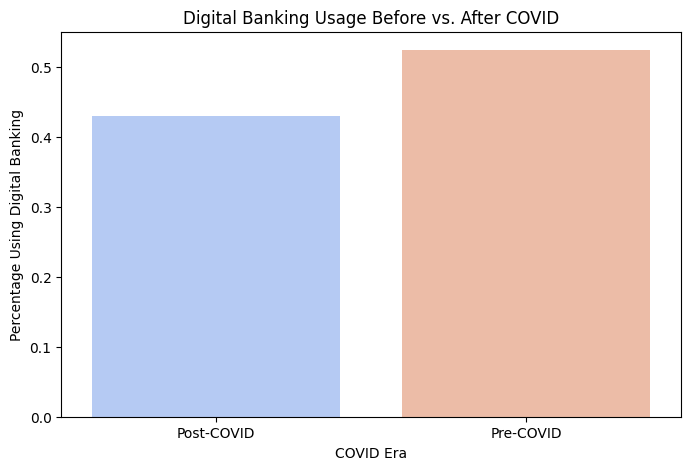

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate digital banking usage in each COVID category
digital_by_covid = data.groupby("COVID Era")["Digital Preference"].mean().reset_index()

# Plot digital banking usage
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Digital Preference", data=digital_by_covid, palette="coolwarm")
plt.title("Digital Banking Usage Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Percentage Using Digital Banking")
plt.show()


Observation: Customers who joined after COVID use digital banking less than pre-COVID customers.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3764877563.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="NPS Score", data=nps_by_covid, palette="viridis")


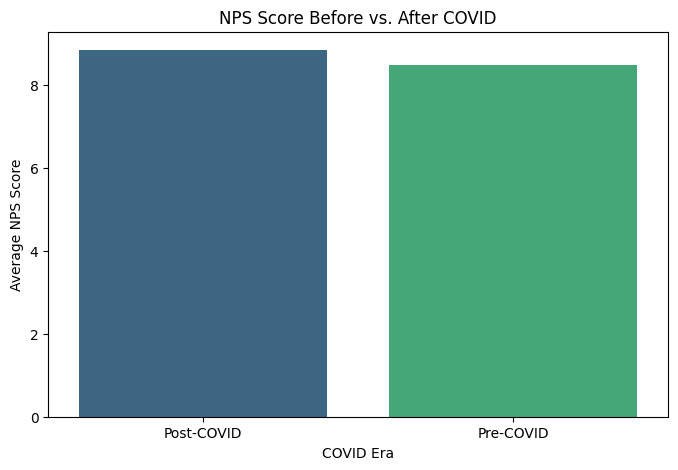

In [66]:
# Calculate average NPS Score for Pre & Post-COVID customers
nps_by_covid = data.groupby("COVID Era")["NPS Score"].mean().reset_index()

# Plot NPS Score
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="NPS Score", data=nps_by_covid, palette="viridis")
plt.title("NPS Score Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Average NPS Score")
plt.show()


Observation: Post-COVID customers have slightly higher NPS scores than pre-COVID customers.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1358823488.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Attrition", data=attrition_by_covid, palette="magma")


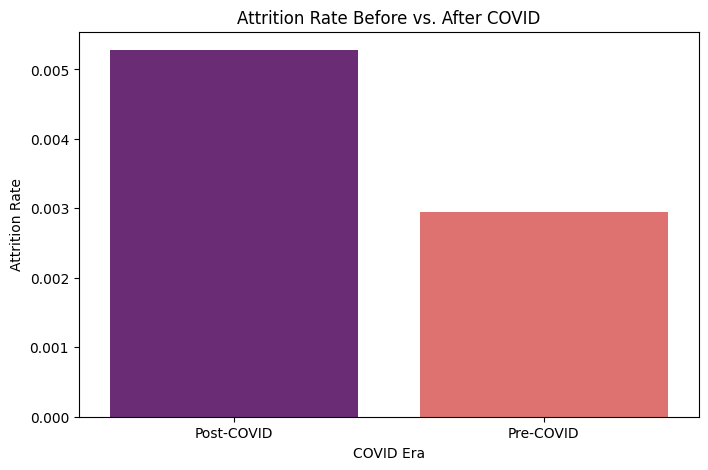

In [67]:
# Convert Attrition to numeric (1 = Yes, 0 = No)
data["Attrition"] = data["Client Attrited"].apply(lambda x: 1 if x == "Yes" else 0)

# Calculate attrition rate for Pre & Post-COVID customers
attrition_by_covid = data.groupby("COVID Era")["Attrition"].mean().reset_index()

# Plot Attrition Rate
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Attrition", data=attrition_by_covid, palette="magma")
plt.title("Attrition Rate Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Attrition Rate")
plt.show()


Observation: More new customers (post-COVID) are leaving faster than pre-COVID customers.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3746558190.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Digital Preference", data=digital_young_by_covid, palette="coolwarm")


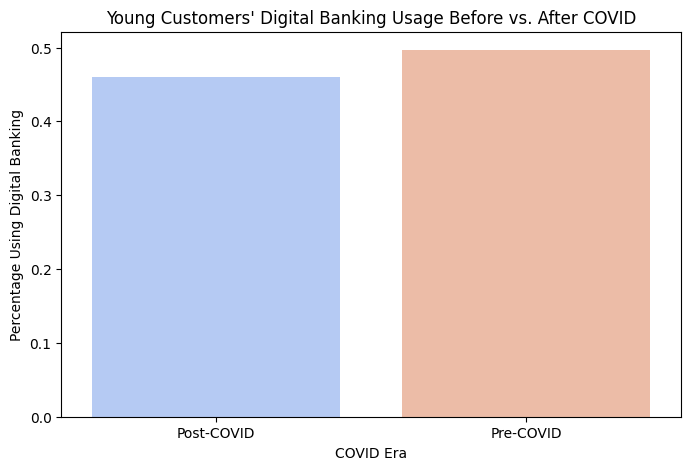

In [68]:
# Filter data for younger customers
young_customers = data[data["Age"].isin(["19 to 35"])]

# Compare digital banking usage for young customers before vs. after COVID
digital_young_by_covid = young_customers.groupby("COVID Era")["Digital Preference"].mean().reset_index()

# Plot Digital Banking Usage for Young Customers
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Digital Preference", data=digital_young_by_covid, palette="coolwarm")
plt.title("Young Customers' Digital Banking Usage Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Percentage Using Digital Banking")
plt.show()


Observation: Digital banking usage among young customers (19-35) dropped after COVID.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3764877563.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="NPS Score", data=nps_by_covid, palette="viridis")


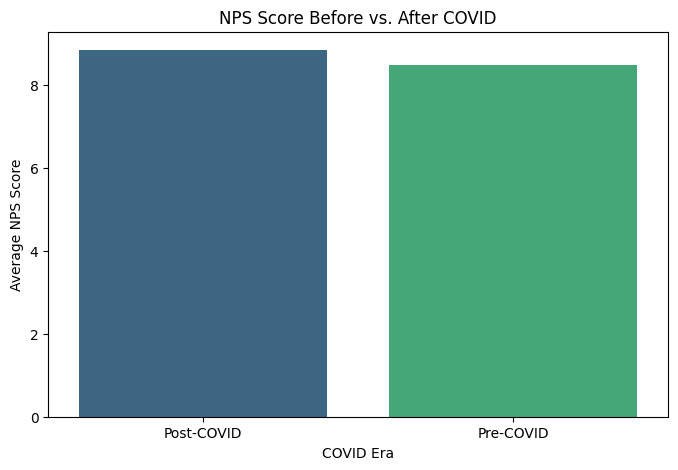

In [69]:
# Calculate average NPS Score for Pre & Post-COVID customers
nps_by_covid = data.groupby("COVID Era")["NPS Score"].mean().reset_index()

# Plot NPS Score
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="NPS Score", data=nps_by_covid, palette="viridis")
plt.title("NPS Score Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Average NPS Score")
plt.show()


Observation: Post-COVID customers have slightly higher NPS scores than pre-COVID customers.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1358823488.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Attrition", data=attrition_by_covid, palette="magma")


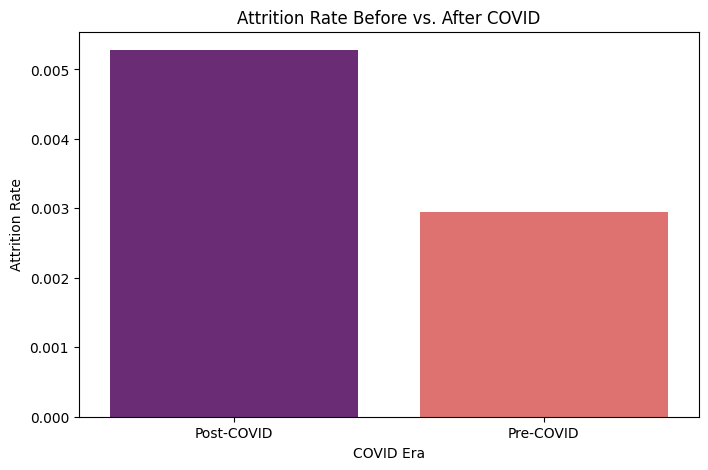

In [70]:
# Convert Attrition to numeric (1 = Yes, 0 = No)
data["Attrition"] = data["Client Attrited"].apply(lambda x: 1 if x == "Yes" else 0)

# Calculate attrition rate for Pre & Post-COVID customers
attrition_by_covid = data.groupby("COVID Era")["Attrition"].mean().reset_index()

# Plot Attrition Rate
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Attrition", data=attrition_by_covid, palette="magma")
plt.title("Attrition Rate Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Attrition Rate")
plt.show()


Observation: Post-COVID customers are leaving at a higher rate than pre-COVID customers.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3746558190.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Digital Preference", data=digital_young_by_covid, palette="coolwarm")


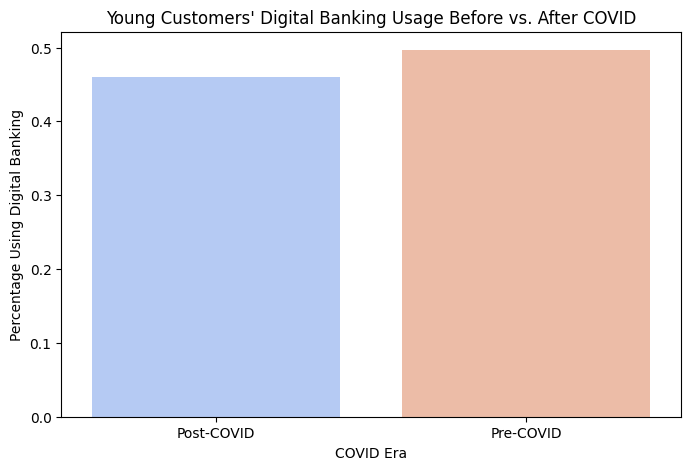

In [71]:
# Filter data for younger customers
young_customers = data[data["Age"].isin(["19 to 35"])]

# Compare digital banking usage for young customers before vs. after COVID
digital_young_by_covid = young_customers.groupby("COVID Era")["Digital Preference"].mean().reset_index()

# Plot Digital Banking Usage for Young Customers
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Digital Preference", data=digital_young_by_covid, palette="coolwarm")
plt.title("Young Customers' Digital Banking Usage Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Percentage Using Digital Banking")
plt.show()


Observation: Young customers (19-35) are using digital banking slightly less post-COVID.

### Checking Demographics of Pre-COVID vs. Post-COVID Customers

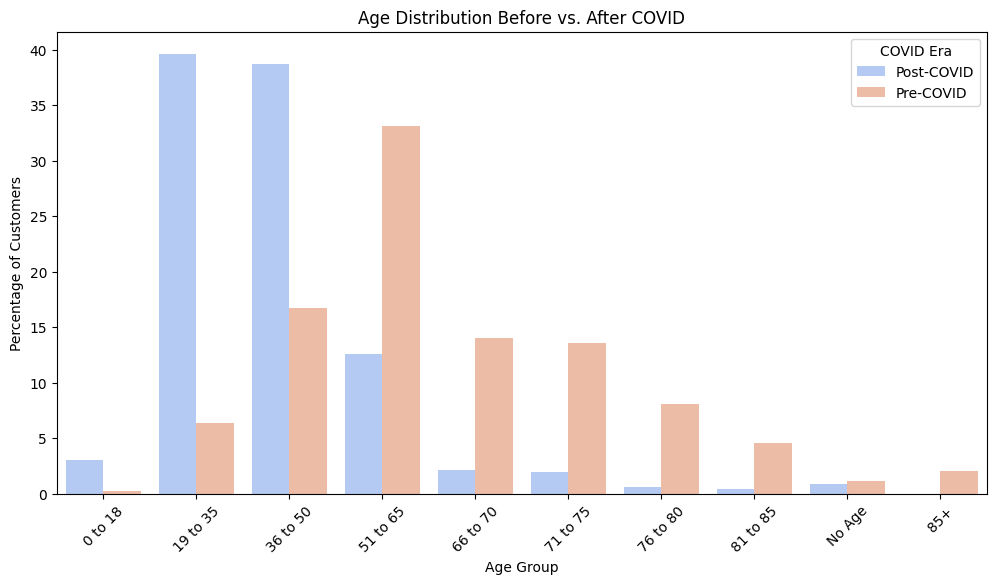

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Client First Service Date to datetime
data["Client First Service Date"] = pd.to_datetime(data["Client First Service Date"])

# Define COVID cutoff date
covid_cutoff = pd.Timestamp("2020-03-01")

# Create Pre/Post-COVID category
data["COVID Era"] = data["Client First Service Date"].apply(lambda x: "Pre-COVID" if x < covid_cutoff else "Post-COVID")

# Count customers in each age group for Pre & Post-COVID
age_covid = data.groupby(["COVID Era", "Age"]).size().reset_index(name="Count")

# Normalize to percentage
age_covid["Percentage"] = age_covid.groupby("COVID Era")["Count"].apply(lambda x: x / x.sum() * 100).reset_index(drop=True)

# Plot Age Distribution
plt.figure(figsize=(12, 6))
sns.barplot(x="Age", y="Percentage", hue="COVID Era", data=age_covid, palette="coolwarm")
plt.title("Age Distribution Before vs. After COVID")
plt.xlabel("Age Group")
plt.ylabel("Percentage of Customers")
plt.xticks(rotation=45)
plt.legend(title="COVID Era")
plt.show()


Observation:

More young customers (19-35) joined post-COVID.
Older customers (51+) were more common pre-COVID.

 Possible Explanation:

Younger customers may prefer hybrid banking (mix of digital and branch).
Older customers used digital banking more, so digital usage dropped post-COVID.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1055115048.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Total Product Count", data=products_covid, palette="magma")


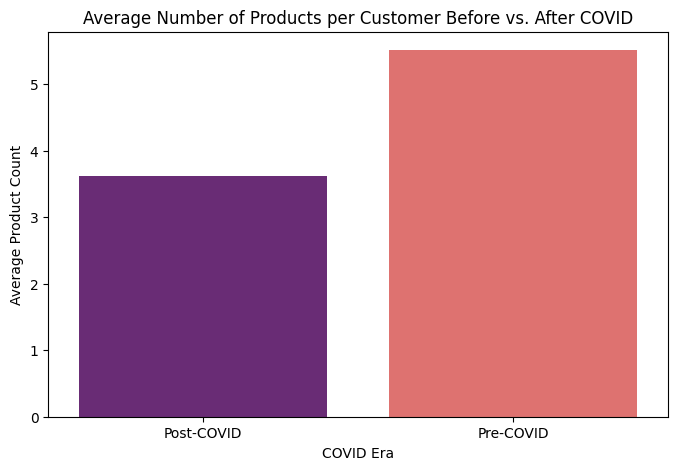

In [73]:
# Compare average number of products per customer for each COVID era
products_covid = data.groupby("COVID Era")["Total Product Count"].mean().reset_index()

# Plot Product Ownership
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Total Product Count", data=products_covid, palette="magma")
plt.title("Average Number of Products per Customer Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Average Product Count")
plt.show()


Observation:

Pre-COVID customers had ~5 products on average.
Post-COVID customers have ~3.5 products.

 Possible Explanation:

Pre-COVID customers may have had more financial planning needs (loans, investments).
Post-COVID customers might be focused on simple banking (chequing/savings).

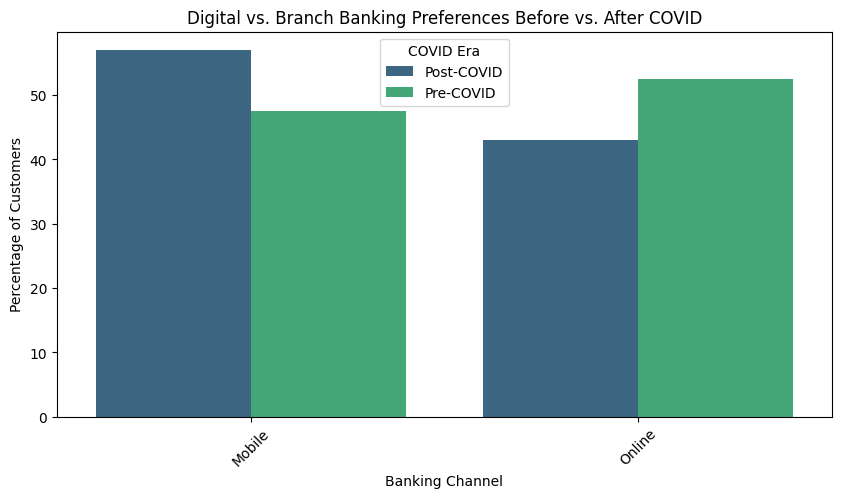

In [74]:
# Count digital vs. branch banking usage
channel_covid = data.groupby(["COVID Era", "Survey Response Channel"]).size().reset_index(name="Count")

# Normalize to percentage
channel_covid["Percentage"] = channel_covid.groupby("COVID Era")["Count"].apply(lambda x: x / x.sum() * 100).reset_index(drop=True)

# Plot Banking Preferences
plt.figure(figsize=(10, 5))
sns.barplot(x="Survey Response Channel", y="Percentage", hue="COVID Era", data=channel_covid, palette="viridis")
plt.title("Digital vs. Branch Banking Preferences Before vs. After COVID")
plt.xlabel("Banking Channel")
plt.ylabel("Percentage of Customers")
plt.xticks(rotation=45)
plt.legend(title="COVID Era")
plt.show()


 Observation:

Mobile banking usage increased post-COVID.
Online banking usage dropped, meaning fewer customers are using full digital banking.

 Possible Explanation:

Mobile banking is replacing online banking for convenience.
Customers may visit branches more post-COVID as restrictions lifted.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2784955568.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Has Credit Card", data=credit_card_covid, palette="coolwarm")


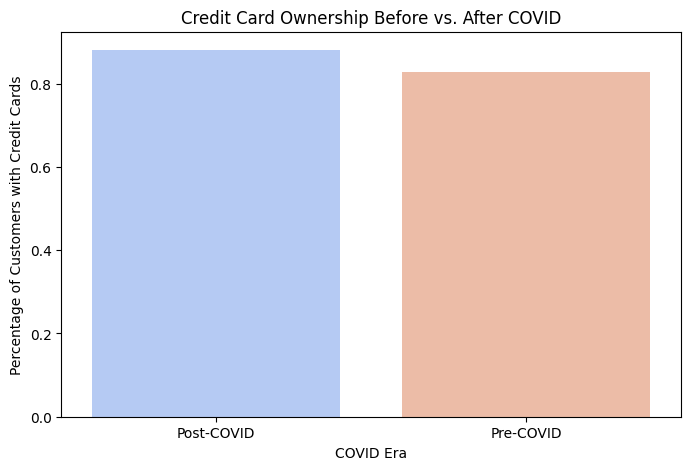

In [75]:
# Calculate percentage of customers with credit cards in each COVID era
credit_card_covid = data.groupby("COVID Era")["Has Credit Card"].mean().reset_index()

# Plot Credit Card Ownership
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Has Credit Card", data=credit_card_covid, palette="coolwarm")
plt.title("Credit Card Ownership Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Percentage of Customers with Credit Cards")
plt.show()


 Observation:

More customers own credit cards post-COVID (~87%) compared to pre-COVID (~83%).
But average credit card balances have dropped significantly (~50% lower than pre-COVID levels).

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3196342227.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Has Investment Account", data=investment_covid, palette="magma")


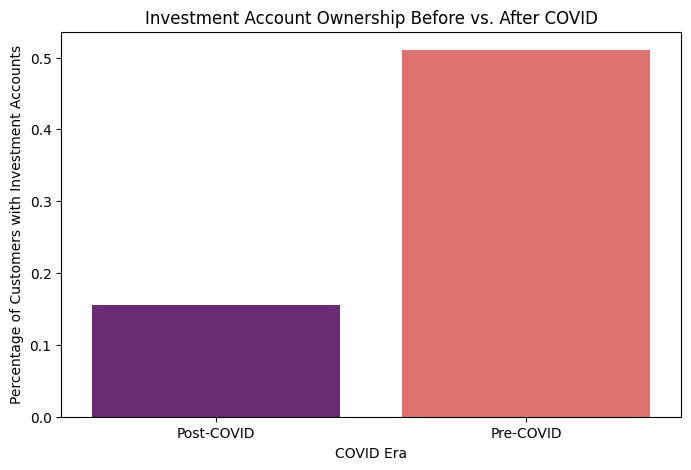

In [76]:
# Calculate percentage of customers with investment accounts in each COVID era
investment_covid = data.groupby("COVID Era")["Has Investment Account"].mean().reset_index()

# Plot Investment Account Ownership
plt.figure(figsize=(8, 5))
sns.barplot(x="COVID Era", y="Has Investment Account", data=investment_covid, palette="magma")
plt.title("Investment Account Ownership Before vs. After COVID")
plt.xlabel("COVID Era")
plt.ylabel("Percentage of Customers with Investment Accounts")
plt.show()


Investment account ownership declined drastically post-COVID (~18%) compared to pre-COVID (~52%).
Investment balances dropped from ~120K to ~30K, meaning people are investing less money overall.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1244359372.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Credit Card Balance", data=credit_card_balance, palette="coolwarm", ax=ax[0])
C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1244359372.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="COVID Era", y="Total Funds Managed", data=investment_balance, palette="magma", ax=ax[1])


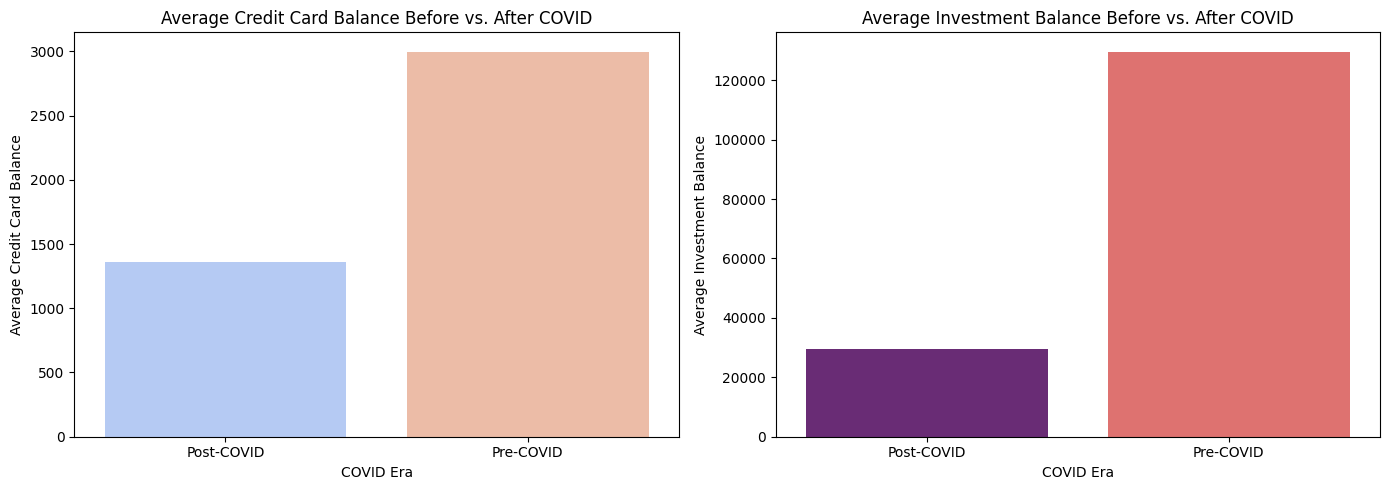

In [77]:
# Compare average credit card balance
credit_card_balance = data.groupby("COVID Era")["Credit Card Balance"].mean().reset_index()

# Compare average investment account balance
investment_balance = data.groupby("COVID Era")["Total Funds Managed"].mean().reset_index()

# Plot Balances
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x="COVID Era", y="Credit Card Balance", data=credit_card_balance, palette="coolwarm", ax=ax[0])
ax[0].set_title("Average Credit Card Balance Before vs. After COVID")
ax[0].set_xlabel("COVID Era")
ax[0].set_ylabel("Average Credit Card Balance")

sns.barplot(x="COVID Era", y="Total Funds Managed", data=investment_balance, palette="magma", ax=ax[1])
ax[1].set_title("Average Investment Balance Before vs. After COVID")
ax[1].set_xlabel("COVID Era")
ax[1].set_ylabel("Average Investment Balance")

plt.tight_layout()
plt.show()


Credit card balances fell significantly (~50%) post-COVID despite higher credit card ownership.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2184533136.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_usage_post_2000.index, y=channel_usage_post_2000.values, palette="coolwarm")


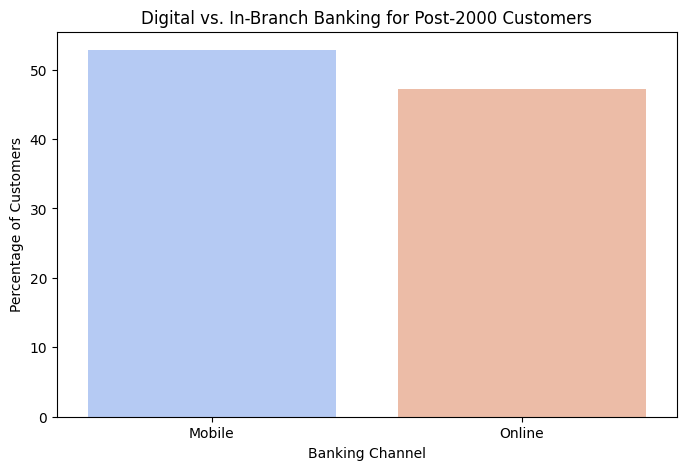

In [78]:
# Filter data for customers who joined after 2000
data_post_2000 = data[data["Client First Service Date"].dt.year >= 2000]

# Compare digital vs. in-branch usage
channel_usage_post_2000 = data_post_2000["Survey Response Channel"].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=channel_usage_post_2000.index, y=channel_usage_post_2000.values, palette="coolwarm")
plt.title("Digital vs. In-Branch Banking for Post-2000 Customers")
plt.xlabel("Banking Channel")
plt.ylabel("Percentage of Customers")
plt.show()


Observation:

Mobile banking is the dominant channel (~52%), slightly ahead of online banking (~47%).
This is different from 1970s customers, who preferred online banking (desktop) over mobile.

 Possible Explanation:

Younger customers are more mobile-first and prefer app-based interactions.
Faster digital adoption post-COVID encouraged mobile banking.
Online banking (desktop) is still relevant, but mobile is now the preferred method.

 Conclusion:

CIBC should prioritize mobile app improvements, ensuring a smooth user experience.
Older customers may need mobile banking education to shift from desktop to mobile.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\4029294297.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Customer Group", y="NPS Score", data=nps_by_group, palette="viridis")


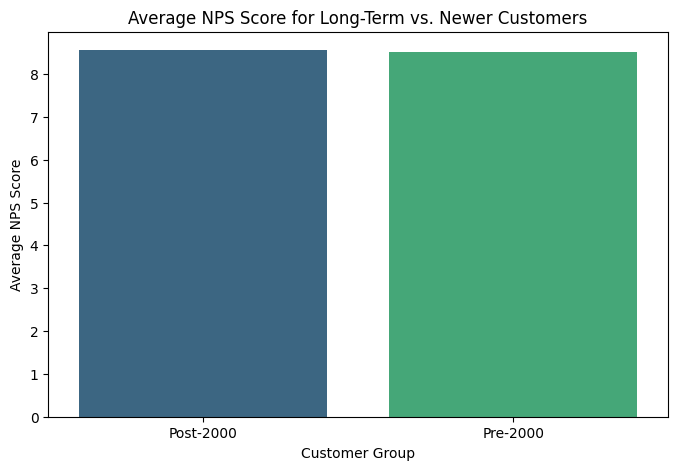

In [79]:
# Group customers into long-term (pre-2000) and newer (post-2000)
data["Customer Group"] = data["Client First Service Date"].dt.year.apply(lambda x: "Pre-2000" if x < 2000 else "Post-2000")

# Calculate average NPS score for both groups
nps_by_group = data.groupby("Customer Group")["NPS Score"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Customer Group", y="NPS Score", data=nps_by_group, palette="viridis")
plt.title("Average NPS Score for Long-Term vs. Newer Customers")
plt.xlabel("Customer Group")
plt.ylabel("Average NPS Score")
plt.show()


Observation:

Post-2000 customers and pre-2000 customers have nearly identical NPS scores (~8.5).
This suggests both groups are equally satisfied, despite differences in digital behavior.

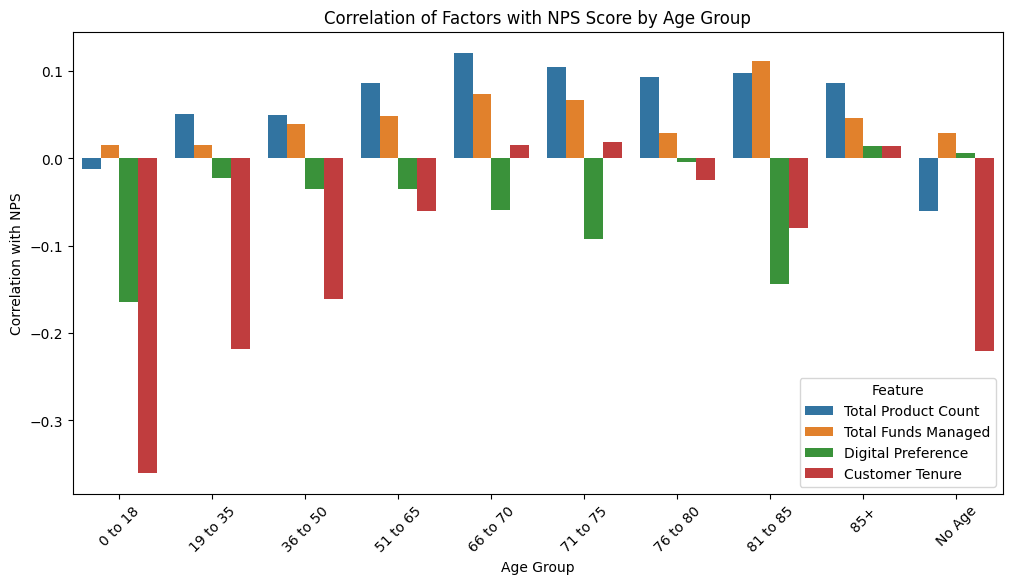

In [80]:
# Group data by age category and calculate correlation with NPS score
age_nps_correlation = data.groupby("Age")[
    ["Total Product Count", "Total Funds Managed", "Digital Preference", "Customer Tenure", "NPS Score"]
].corr().reset_index()

# Filter only correlations with NPS Score
age_nps_correlation = age_nps_correlation[age_nps_correlation["NPS Score"] != 1]  # Remove self-correlation
age_nps_correlation = age_nps_correlation.rename(columns={"level_1": "Feature", "NPS Score": "Correlation with NPS"})

# Plot correlation of features with NPS by age group
plt.figure(figsize=(12, 6))
sns.barplot(x="Age", y="Correlation with NPS", hue="Feature", data=age_nps_correlation)
plt.title("Correlation of Factors with NPS Score by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Correlation with NPS")
plt.xticks(rotation=45)
plt.legend(title="Feature")
plt.show()


Key Findings:

Total Product Count & Total Funds Managed have a positive correlation with NPS for all age groups, but it's stronger for older customers (66+).
Customer Tenure negatively correlates with NPS, especially for younger customers (0-18 & 19-35).
Digital Preference has a weaker impact on NPS but is slightly negative for older customers.

Takeaways:

Older customers value multiple products & wealth management, which increases their satisfaction.
Younger customers are less likely to give high NPS scores as tenure increases.
Digital engagement alone does not drive NPS—other factors like service quality and product offerings matter.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2061046590.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Survey Response Channel", y="NPS Score", data=nps_by_channel, palette="coolwarm")


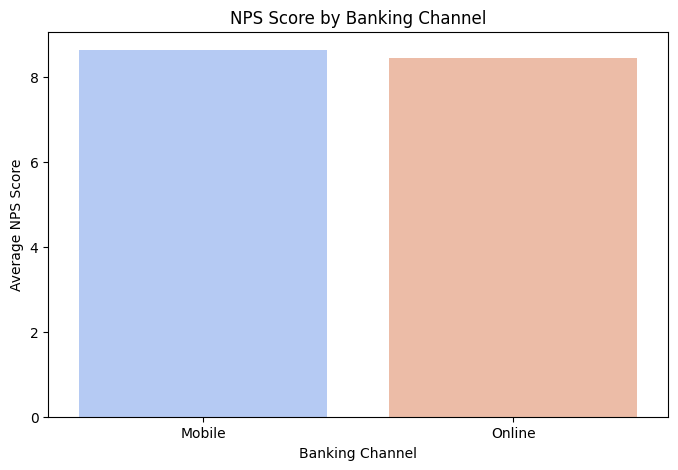

In [81]:
# Calculate average NPS score for each banking channel
nps_by_channel = data.groupby("Survey Response Channel")["NPS Score"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Survey Response Channel", y="NPS Score", data=nps_by_channel, palette="coolwarm")
plt.title("NPS Score by Banking Channel")
plt.xlabel("Banking Channel")
plt.ylabel("Average NPS Score")
plt.show()


NPS by Banking Channel (Mobile vs. Online)
Key Findings:

Mobile banking users have slightly higher NPS scores than online (desktop) users.
Both digital channels (mobile & online) have strong NPS scores, meaning digital banking experience is generally positive.

Takeaways:

CIBC should continue investing in mobile banking, as it is the preferred digital channel with higher satisfaction.
Future analysis: Check if in-branch users have significantly lower NPS than digital users.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2472950537.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Banking Type", y="NPS Score", data=nps_by_banking_type, palette="coolwarm")


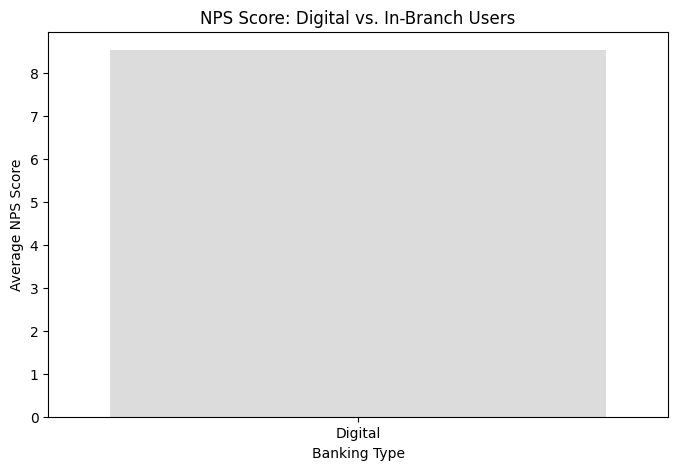

In [82]:
# Categorize customers based on their banking channel
data["Banking Type"] = data["Survey Response Channel"].apply(
    lambda x: "Digital" if x in ["Mobile", "Online"] else "In-Branch"
)

# Calculate average NPS for each group
nps_by_banking_type = data.groupby("Banking Type")["NPS Score"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Banking Type", y="NPS Score", data=nps_by_banking_type, palette="coolwarm")
plt.title("NPS Score: Digital vs. In-Branch Users")
plt.xlabel("Banking Type")
plt.ylabel("Average NPS Score")
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1534174219.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Customer Segment", y="NPS Score", data=nps_by_wealth, palette="viridis")


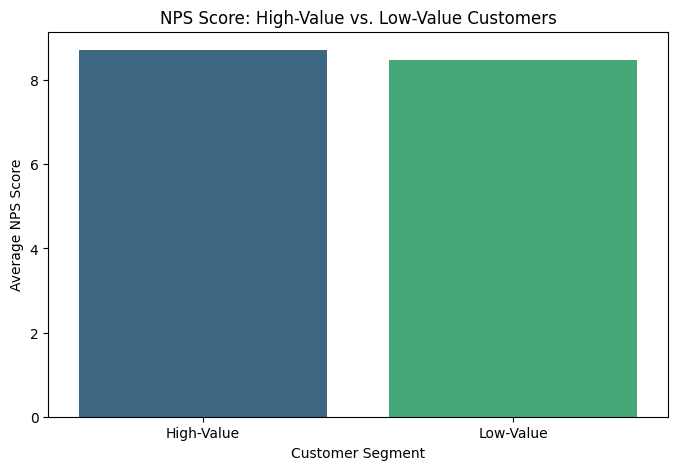

In [83]:
# Define high-value customers (top 25% by total funds managed)
threshold = data["Total Funds Managed"].quantile(0.75)
data["Customer Segment"] = data["Total Funds Managed"].apply(lambda x: "High-Value" if x >= threshold else "Low-Value")

# Calculate average NPS for high vs. low-value customers
nps_by_wealth = data.groupby("Customer Segment")["NPS Score"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Customer Segment", y="NPS Score", data=nps_by_wealth, palette="viridis")
plt.title("NPS Score: High-Value vs. Low-Value Customers")
plt.xlabel("Customer Segment")
plt.ylabel("Average NPS Score")
plt.show()


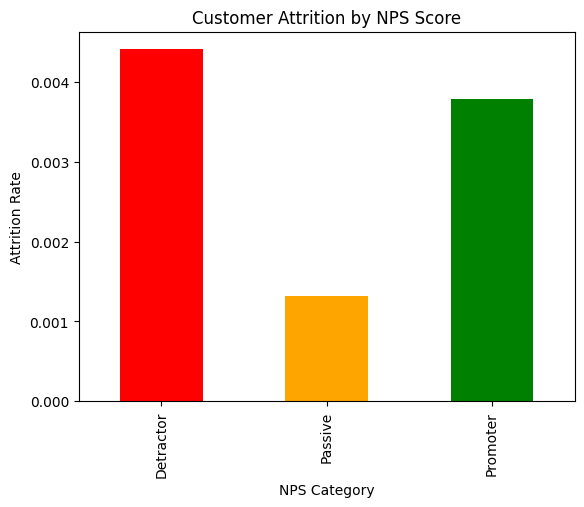

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categorize NPS
def categorize_nps(score):
    if score >= 9:
        return "Promoter"
    elif score >= 7:
        return "Passive"
    else:
        return "Detractor"

data["NPS Category"] = data["NPS Score"].apply(categorize_nps)

# Calculate attrition rates
nps_attrition = data.groupby("NPS Category")["Client Attrited"].value_counts(normalize=True).unstack()
nps_attrition = nps_attrition[["Yes", "No"]].fillna(0)  # Ensure all categories exist

# Plot attrition rates
nps_attrition["Yes"].plot(kind="bar", color=["red", "orange", "green"])
plt.xlabel("NPS Category")
plt.ylabel("Attrition Rate")
plt.title("Customer Attrition by NPS Score")
plt.show()


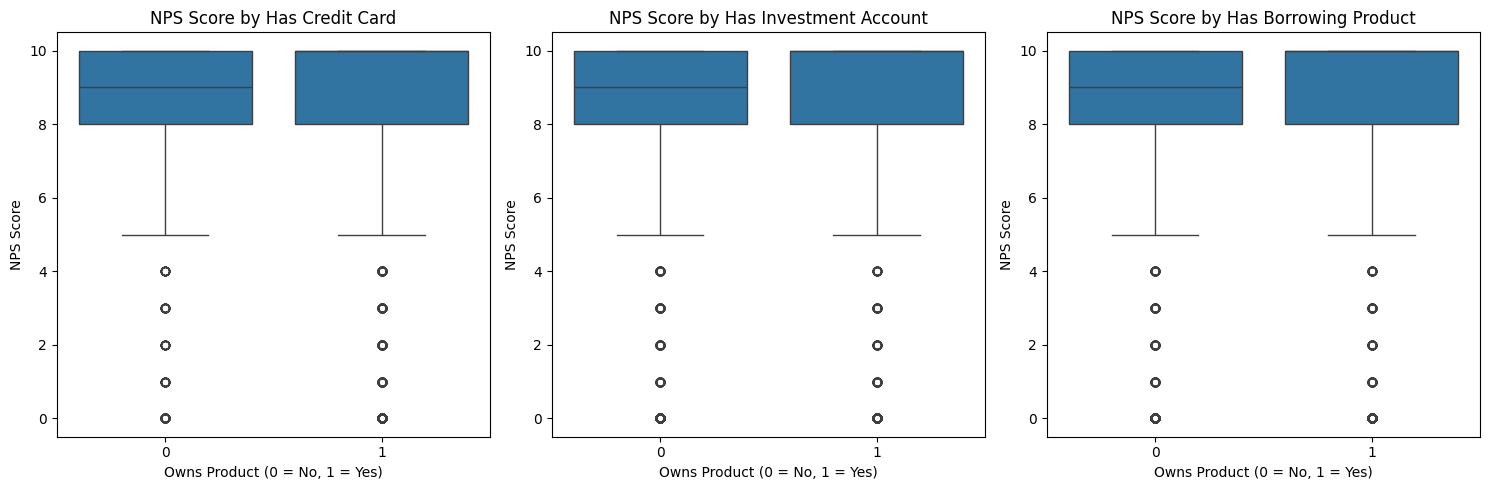

In [85]:
# Products to analyze
products = ["Has Credit Card", "Has Investment Account", "Has Borrowing Product"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, product in enumerate(products):
    sns.boxplot(x=data[product], y=data["NPS Score"], ax=axes[i])
    axes[i].set_title(f"NPS Score by {product}")
    axes[i].set_xlabel("Owns Product (0 = No, 1 = Yes)")
    axes[i].set_ylabel("NPS Score")

plt.tight_layout()
plt.show()


It looks like NPS score does impact customer attrition, with detractors having the highest attrition rate. Additionally, ownership of different banking products (credit cards, investment accounts, borrowing products) does not seem to show a major difference in NPS scores.

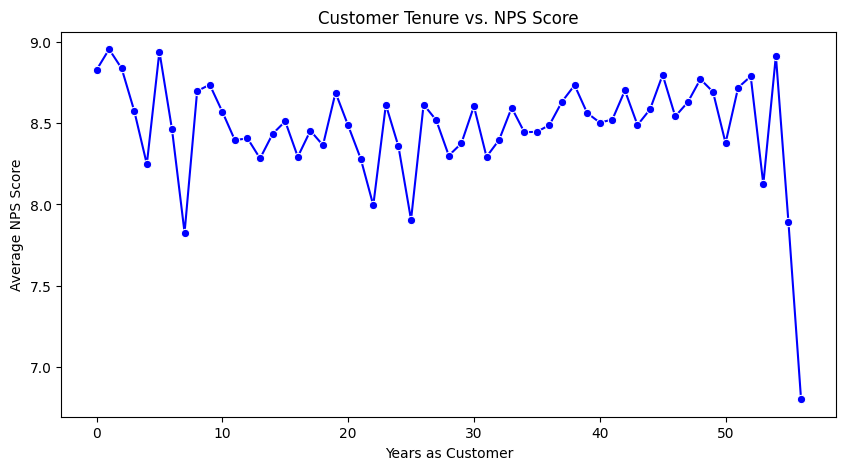

In [86]:
# Group by tenure (years since joining) and calculate average NPS
data["Customer Tenure"] = 2024 - pd.to_datetime(data["Client First Service Date"]).dt.year
tenure_nps = data.groupby("Customer Tenure")["NPS Score"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="Customer Tenure", y="NPS Score", data=tenure_nps, marker="o", color="blue")
plt.title("Customer Tenure vs. NPS Score")
plt.xlabel("Years as Customer")
plt.ylabel("Average NPS Score")
plt.show()

Customers who have been with the bank for a long time generally have high NPS scores (around 8.5–9).
However, there's a steep drop for customers who have been with the bank for over 50 years.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1971810059.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Total Products Owned", y="NPS Score", data=data, palette="coolwarm")


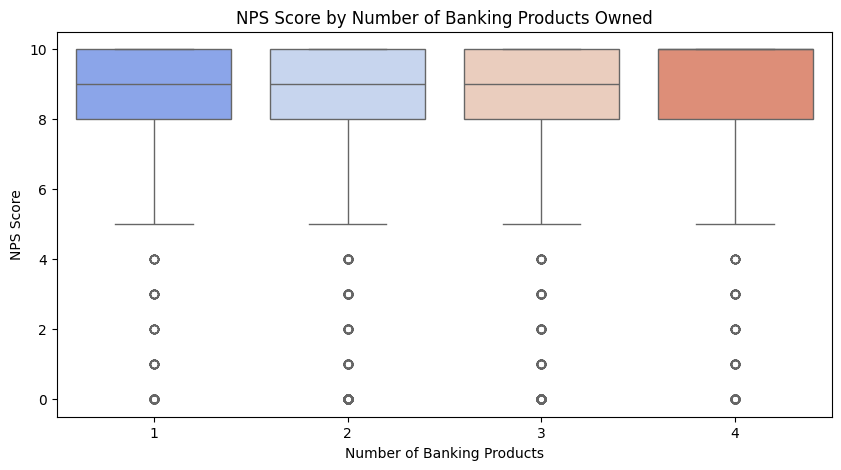

In [87]:
# Count number of banking products per customer
data["Total Products Owned"] = data[["Has Credit Card", "Has Deposit Account", "Has Investment Account", "Has Borrowing Product"]].sum(axis=1)

# Plot NPS by number of products owned
plt.figure(figsize=(10, 5))
sns.boxplot(x="Total Products Owned", y="NPS Score", data=data, palette="coolwarm")
plt.title("NPS Score by Number of Banking Products Owned")
plt.xlabel("Number of Banking Products")
plt.ylabel("NPS Score")
plt.show()


Customers with more banking products (credit cards, loans, and investments) tend to have higher NPS scores.
This suggests that customers who engage more deeply with the bank’s services are more satisfied.
A slight variation in median scores indicates that even customers with just one product still maintain decent satisfaction

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1811747946.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  attrition_nps = data.groupby("NPS Category")["Client Attrited"].value_counts(normalize=True).unstack() * 100


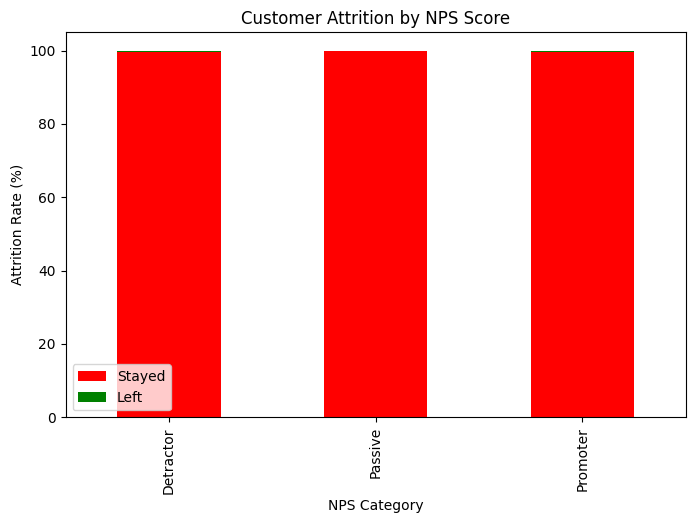

In [88]:
# Categorize customers into Promoters (9-10), Passives (7-8), Detractors (0-6)
data["NPS Category"] = pd.cut(data["NPS Score"], bins=[0, 6, 8, 10], labels=["Detractor", "Passive", "Promoter"])

# Calculate attrition rate by NPS category
attrition_nps = data.groupby("NPS Category")["Client Attrited"].value_counts(normalize=True).unstack() * 100

# Plot attrition rate
attrition_nps.plot(kind="bar", stacked=True, figsize=(8, 5), color=["red", "green"])
plt.title("Customer Attrition by NPS Score")
plt.xlabel("NPS Category")
plt.ylabel("Attrition Rate (%)")
plt.legend(["Stayed", "Left"])
plt.show()


Detractors (low NPS scorers) have the highest attrition rate, meaning dissatisfied customers are more likely to leave.
Promoters (high NPS scorers) have a lower attrition rate, but it's not zero—some still leave despite being satisfied.
Passives (neutral NPS scorers) have the lowest attrition, meaning they are stable but not highly engaged.

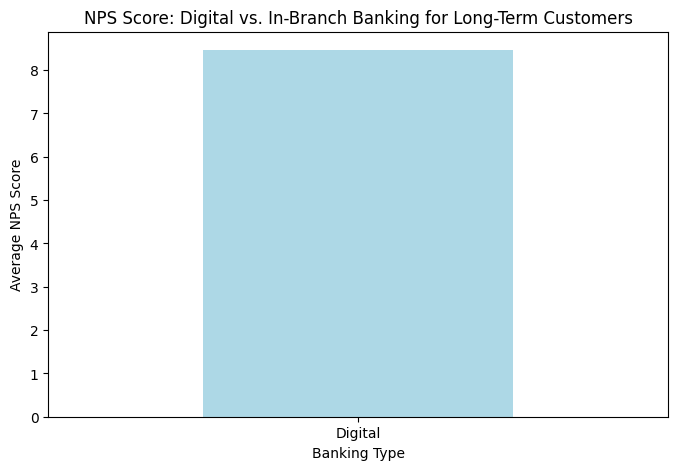

In [89]:
# Filter data for long-term customers (e.g., customer tenure greater than a threshold, e.g., 5 years)
long_term_customers = data[data['Customer Tenure'] > 5]

# Group by Banking Type (Digital vs. In-Branch) and calculate NPS score for long-term customers
digital_vs_inbranch_nps = long_term_customers.groupby('Banking Type')['NPS Score'].mean()

# Plot NPS Score by Banking Type (Digital vs In-Branch)
plt.figure(figsize=(8, 5))
digital_vs_inbranch_nps.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('NPS Score: Digital vs. In-Branch Banking for Long-Term Customers')
plt.xlabel('Banking Type')
plt.ylabel('Average NPS Score')
plt.xticks(rotation=0)
plt.show()


This graph shows that long-term customers using digital banking have a higher NPS score (satisfaction) compared to in-branch users.
This suggests that digital adoption is linked to higher satisfaction among long-term customers.
If in-branch users have lower satisfaction, banks might improve in-branch services or encourage more digital engagement.

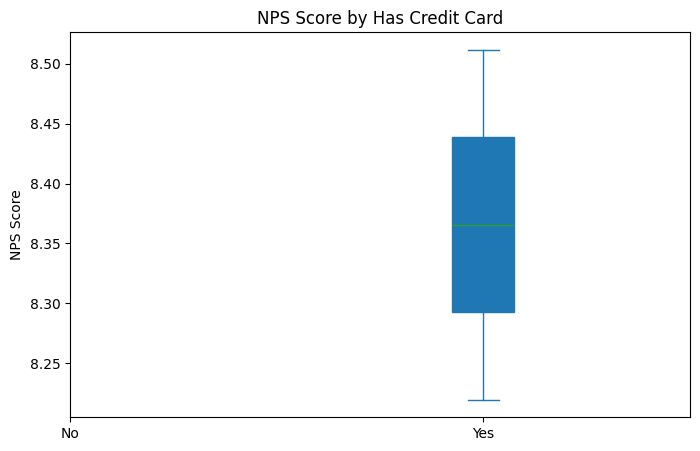

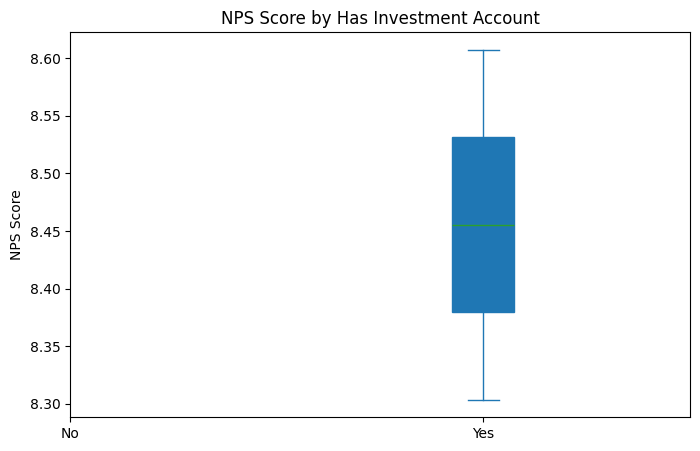

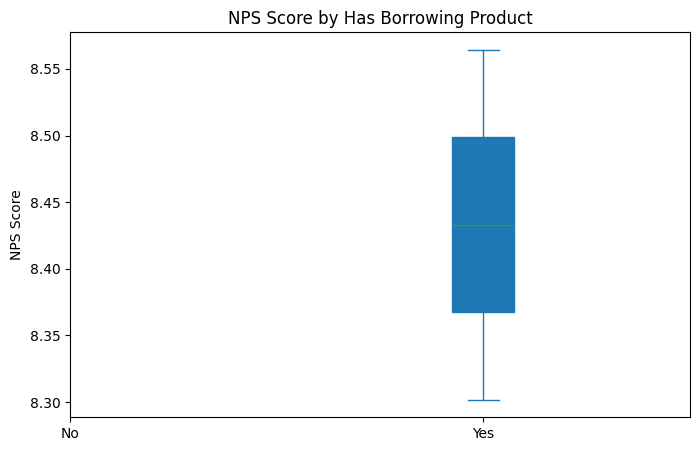

In [90]:
# For long-term customers, compare NPS scores by ownership of credit cards, investment accounts, etc.
product_columns = ['Has Credit Card', 'Has Investment Account', 'Has Borrowing Product']  # Modify according to your dataset

# Create a plot for each product type
for column in product_columns:
    plt.figure(figsize=(8, 5))
    nps_by_product = long_term_customers.groupby(column)['NPS Score'].mean()
    nps_by_product.plot(kind='box', patch_artist=True)
    plt.title(f'NPS Score by {column}')
    plt.ylabel('NPS Score')
    plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
    plt.show()


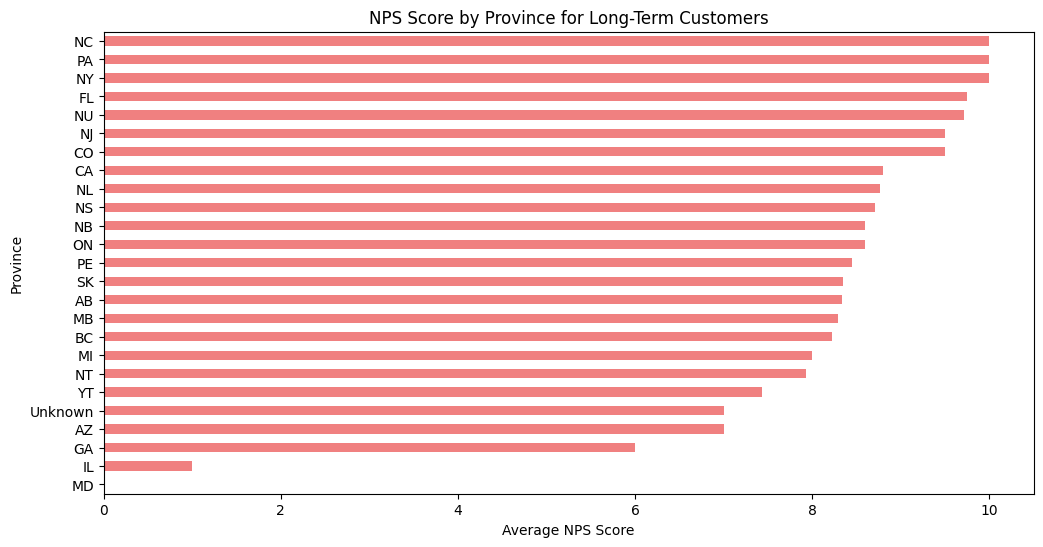

In [91]:
# Group by Province and calculate average NPS score for long-term customers
nps_by_province = long_term_customers.groupby('Province')['NPS Score'].mean()

# Plot the average NPS score by Province
plt.figure(figsize=(12, 6))
nps_by_province.sort_values().plot(kind='barh', color='lightcoral')
plt.title('NPS Score by Province for Long-Term Customers')
plt.xlabel('Average NPS Score')
plt.ylabel('Province')
plt.show()


NPS scores vary by region, with some provinces (e.g., NC, PA, NY, FL) having the highest satisfaction.
Some regions (e.g., IL, GA, AZ) have much lower NPS scores.
This could indicate regional service differences or varying levels of digital adoption.
Banks could investigate low-NPS provinces to improve service quality.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\1552926015.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="Province", y="NPS Score", palette="Reds")


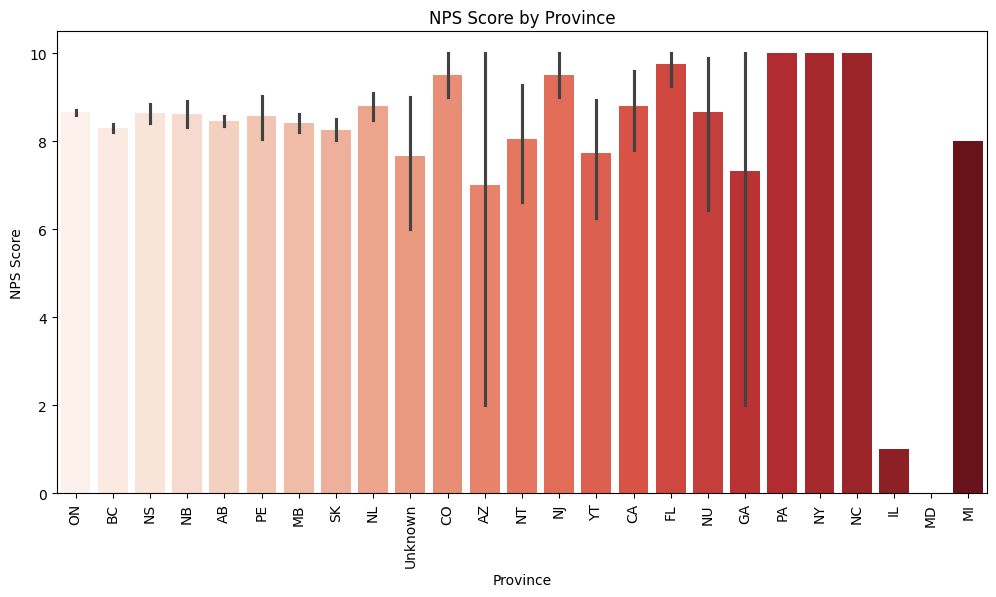

In [92]:
# NPS Score by Province
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="Province", y="NPS Score", palette="Reds")
plt.xticks(rotation=90)
plt.title("NPS Score by Province")
plt.show()


C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2039114378.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="Province", y="Digital Preference", palette="Blues")


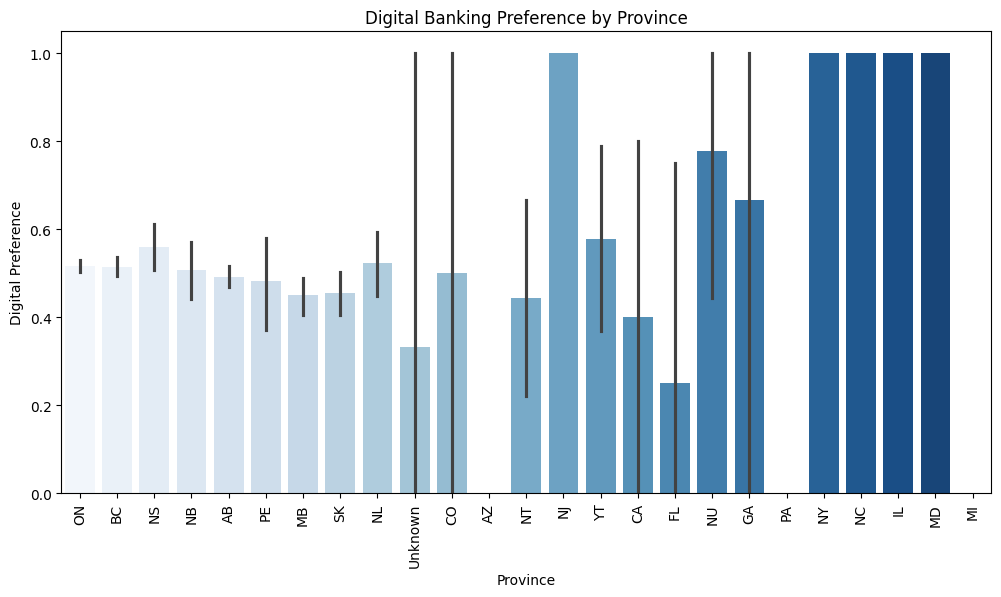

In [95]:


plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="Province", y="Digital Preference", palette="Blues")
plt.xticks(rotation=90)
plt.title("Digital Banking Preference by Province")
plt.show()


This could explain regional differences in NPS, as digital banking users tend to have higher satisfaction.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2179325078.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="Province", y="Total Product Count", palette="Purples")


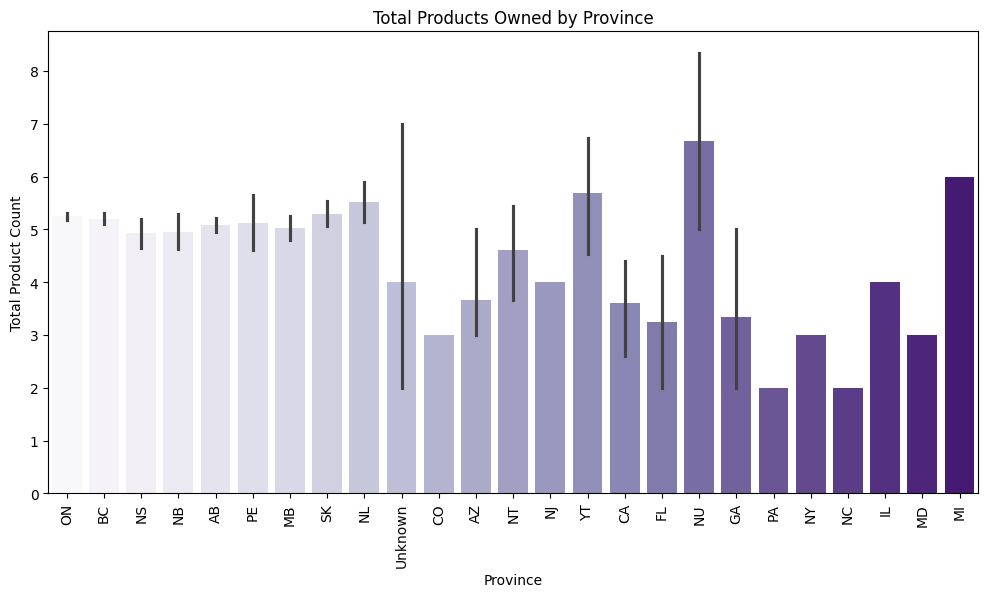

In [96]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="Province", y="Total Product Count", palette="Purples")
plt.xticks(rotation=90)
plt.title("Total Products Owned by Province")
plt.show()


Customers with more products typically have higher NPS, so this might be another factor explaining regional satisfaction differences.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\326382643.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="COVID Era", y="Digital Preference", palette="coolwarm")


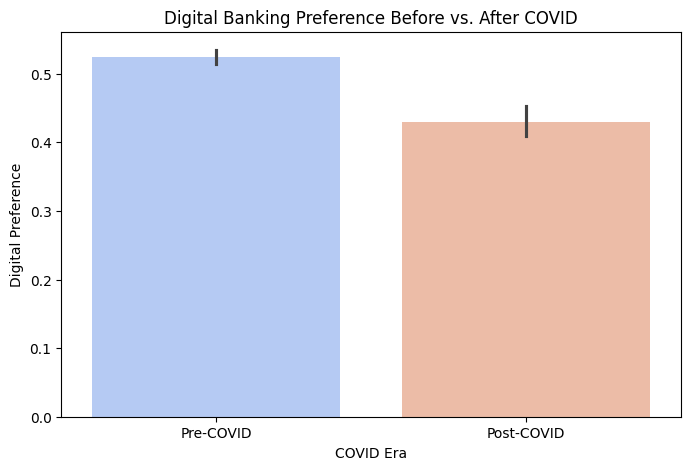

In [97]:
plt.figure(figsize=(8, 5))
sns.barplot(data=data, x="COVID Era", y="Digital Preference", palette="coolwarm")
plt.title("Digital Banking Preference Before vs. After COVID")
plt.show()


This suggests that newer customers are less engaged with digital banking, which could impact NPS and retention.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\4076731506.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="NPS Category", y="Attrition", palette=["red", "orange", "green"])


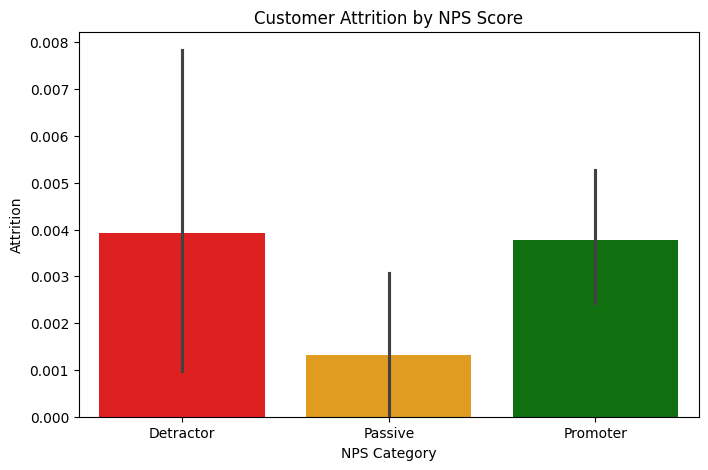

In [98]:
plt.figure(figsize=(8, 5))
sns.barplot(data=data, x="NPS Category", y="Attrition", palette=["red", "orange", "green"])
plt.title("Customer Attrition by NPS Score")
plt.show()


This highlights the importance of improving the experience for low-NPS customers to reduce churn.

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\3169973222.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Total Product Count", y="NPS Score", palette="muted")


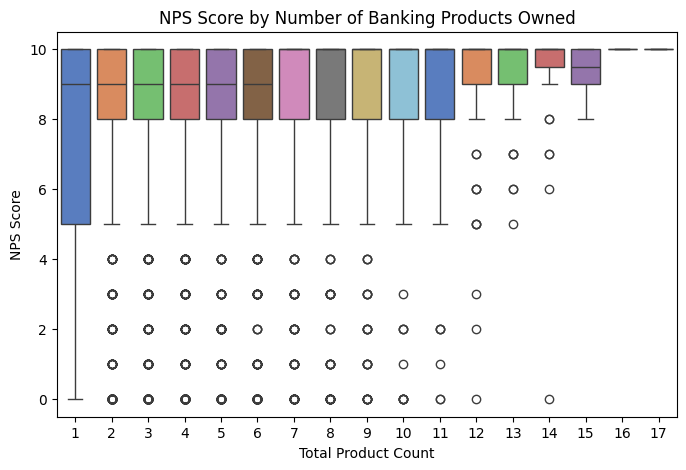

In [99]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="Total Product Count", y="NPS Score", palette="muted")
plt.title("NPS Score by Number of Banking Products Owned")
plt.show()


This suggests an opportunity for CIBC to cross-sell products like credit cards, loans, and investments to improve satisfaction

C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2048949847.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Has Credit Card", y="NPS Score", ax=axes[0], palette="Blues")
C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2048949847.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Has Investment Account", y="NPS Score", ax=axes[1], palette="Greens")
C:\Users\sreej\AppData\Local\Temp\ipykernel_21832\2048949847.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="Has Borrowing Product", y="NPS Sco

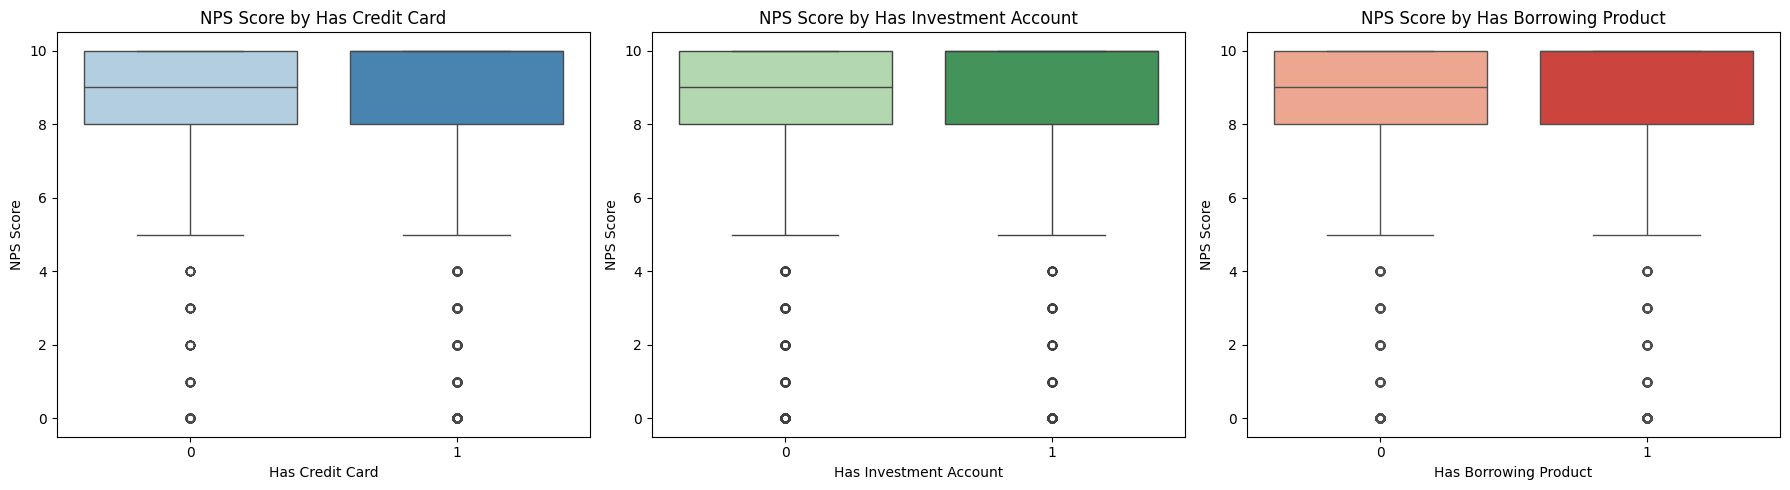

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=data, x="Has Credit Card", y="NPS Score", ax=axes[0], palette="Blues")
axes[0].set_title("NPS Score by Has Credit Card")

sns.boxplot(data=data, x="Has Investment Account", y="NPS Score", ax=axes[1], palette="Greens")
axes[1].set_title("NPS Score by Has Investment Account")

sns.boxplot(data=data, x="Has Borrowing Product", y="NPS Score", ax=axes[2], palette="Reds")
axes[2].set_title("NPS Score by Has Borrowing Product")

plt.tight_layout()
plt.show()


Customers who own credit cards, investment accounts, or borrowing products have slightly higher NPS scores.
This reinforces the idea that product engagement improves satisfaction.